# Telecom Churn Case Study
###### ML Models built by Kedar Lachke and Preeti Shrivastava

### Logistic Regression and Random Forest


Models will be implementing using following step
1. Data Analysis
2. Filling the missing Data
3. Drop Column with zero variance
4. Plot some graph to analyse data
5. Try Logistic Regression
6. Try Random Forest 
7. Try PCA

###### Common import statements

In [362]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')
#import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE , SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model, metrics
from sklearn.decomposition import PCA
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix

###### Common functions

In [363]:
# Find NaN values using isna() or isnull()
def print_missing_values(df):
    missing_values = df.isna().sum()
    # Filter columns with missing values and print their names and counts
    columns_with_missing_values = missing_values[missing_values > 0]
    print("\nColumns with Missing Values:")
    for column_name, missing_count in columns_with_missing_values.items():
        print(f"{column_name}: {missing_count} missing values")
        
#function to replace na,'','NA' with 0 for array of numeric input columns in the input df
def replace_na_with_zero(df, column_names):
    for column_name in column_names:
        df[column_name] = df[column_name].apply(lambda x: 0 if pd.isna(x) or x == '' or str(x).strip() == 'NA' else x)
    return df

#function to replace na,'','NA' with 0 for array of numeric input columns in the input df
def find_numeric_columns(df):
    # Iterate through the specified column names
    numeric_columns = df.select_dtypes(include=[int, float]).columns.tolist()  
    return numeric_columns

def drop_columns_with_zeros(df, list_of_numeric_columns):
    # Define a function to check if a value is a numeric zero
    def is_numeric_zero(value):
        try:
            # Attempt to convert the value to a float
            numeric_value = float(value)
            return numeric_value == 0
        except (ValueError, TypeError):
            return False
    
    for column_name in list_of_numeric_columns:
        # Use the is_numeric_zero function to check if all values in the column are zeros
        if all(df[column_name].apply(is_numeric_zero)):
            df = df.drop(column_name, axis=1)
    return df



In [364]:
#cap outliers to 3 times standard deviation
def cap_outliers(df, numeric_column_list):
    """
    Caps outliers in the specified numeric columns of the DataFrame using mean and standard deviation.

    Parameters:
    - df: DataFrame
        The input DataFrame.
    - numeric_column_list: list
        List of column names to cap outliers in.

    Returns:
    - DataFrame
        The DataFrame with capped outliers in the specified columns.
    """
    capped_df = df.copy()  # Create a copy to avoid modifying the original DataFrame
    
    for column in numeric_column_list:
        # Calculate the mean and standard deviation of the column
        mean_value = df[column].mean()
        std_value = df[column].std()
        
        # Calculate the lower and upper bounds for capping based on mean and standard deviation
        lower_bound_column = mean_value - 3 * std_value
        upper_bound_column = mean_value + 3 * std_value

        # Cap the outliers in the column
        capped_df[column] = capped_df[column].apply(
            lambda x: lower_bound_column if x < lower_bound_column else (upper_bound_column if x > upper_bound_column else x)
        )
    
    return capped_df

In [365]:
def do_box_plot_3(df,x,y):
    plt.figure(figsize=(20, 12))
    plt.subplot(2,3,1)
    sns.boxplot(x = x , y = y +'_6', data = df)
    plt.subplot(2,3,2)
    sns.boxplot(x = x , y = y +'_7', data = df)
    plt.subplot(2,3,3)
    sns.boxplot(x = x , y = y +'_8', data = df)
    
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None    

In [366]:
#Train and print model summary
#Show error term distribution
#return model for selected_coulumns
def train_print_summary(column_list,X_train,y_train):
    X_train_lm = X_train[column_list]
    X_train_lm = sm.add_constant(X_train_lm)    
    lr = sm.OLS(y_train, X_train_lm).fit()
    print(lr.summary())
    y_train_cnt = lr.predict(X_train_lm)
    fig = plt.figure()
    sns.distplot((y_train - y_train_cnt), bins = 20)
    fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
    plt.xlabel('Errors', fontsize = 18)
    return lr

def vif_print_summary(column_list,X_train):
    X_train_vif=X_train[column_list]
    vif = pd.DataFrame()
    vif['Features'] = X_train_vif.columns
    vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

###### Import Data train and unseen data


In [367]:
df_train_preprocess = pd.read_csv("train.csv")
df_unseen_preprocess = pd.read_csv("test.csv")

In [368]:
#list_of_numeric_columns.remove('churn_probability')
list_of_numeric_columns=find_numeric_columns(df_train_preprocess)
print(df_train_preprocess.shape)
list_of_numeric_columns.remove('churn_probability')

(69999, 172)


In [369]:

#replace all numeric columns null values with 0 in train data
df_train_preprocess=replace_na_with_zero(df_train_preprocess,list_of_numeric_columns)
#replace all numeric columns null values with 0 in unseen data
df_unseen_preprocess=replace_na_with_zero(df_unseen_preprocess,list_of_numeric_columns)

In [370]:
#remove circle id from both Train and unseen data
df_train_preprocess = df_train_preprocess.drop('circle_id', axis=1)
df_unseen_preprocess = df_unseen_preprocess.drop('circle_id', axis=1)

In [371]:
#drop date columns
columns_to_drop = ['last_date_of_month_6', 
                   'last_date_of_month_7',
                   'last_date_of_month_8',
                   'date_of_last_rech_6',
                   'date_of_last_rech_7',
                   'date_of_last_rech_8',
                   'date_of_last_rech_data_6',
                   'date_of_last_rech_data_7',
                   'date_of_last_rech_data_8']
# Drop the specified columns
df_train_preprocess = df_train_preprocess.drop(columns=columns_to_drop, axis=1)
df_unseen_preprocess = df_unseen_preprocess.drop(columns=columns_to_drop, axis=1)

In [372]:
list_of_numeric_columns_1=find_numeric_columns(df_train_preprocess)

#remove id and churn_probability
list_of_numeric_columns_1.remove('id')
list_of_numeric_columns_1.remove('churn_probability')

df_train_preprocess = cap_outliers(df_train_preprocess,list_of_numeric_columns_1)
df_unseen_preprocess = cap_outliers(df_unseen_preprocess,list_of_numeric_columns_1)

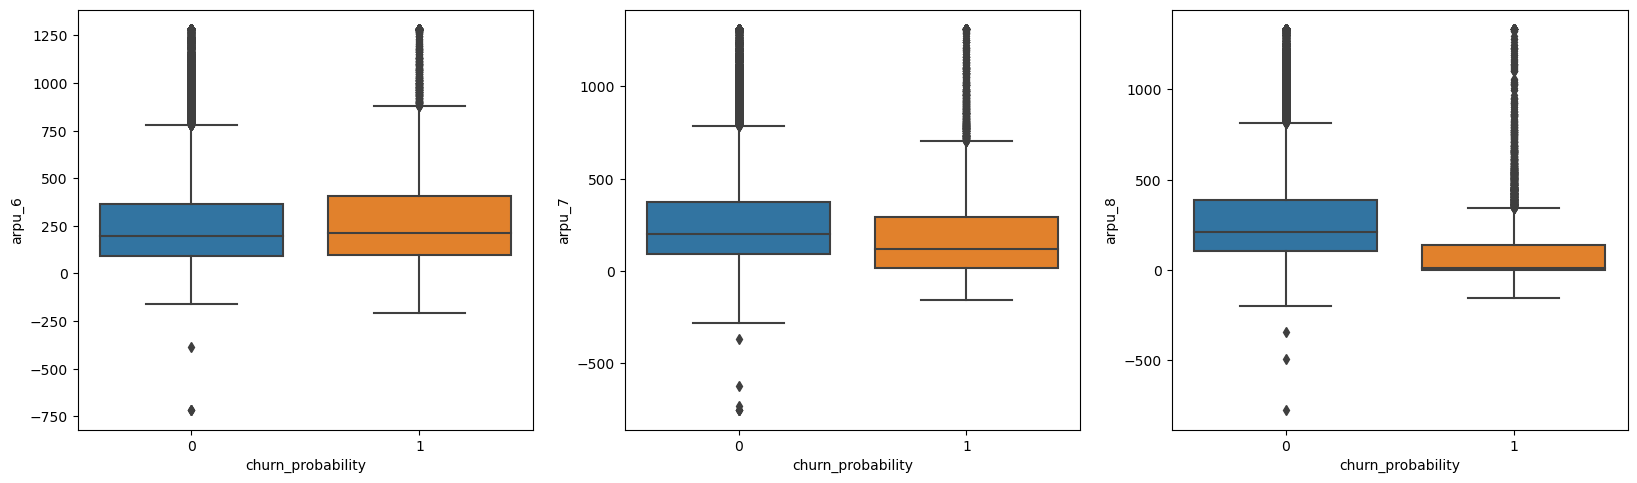

In [373]:
do_box_plot_3(df_train_preprocess,'churn_probability','arpu')

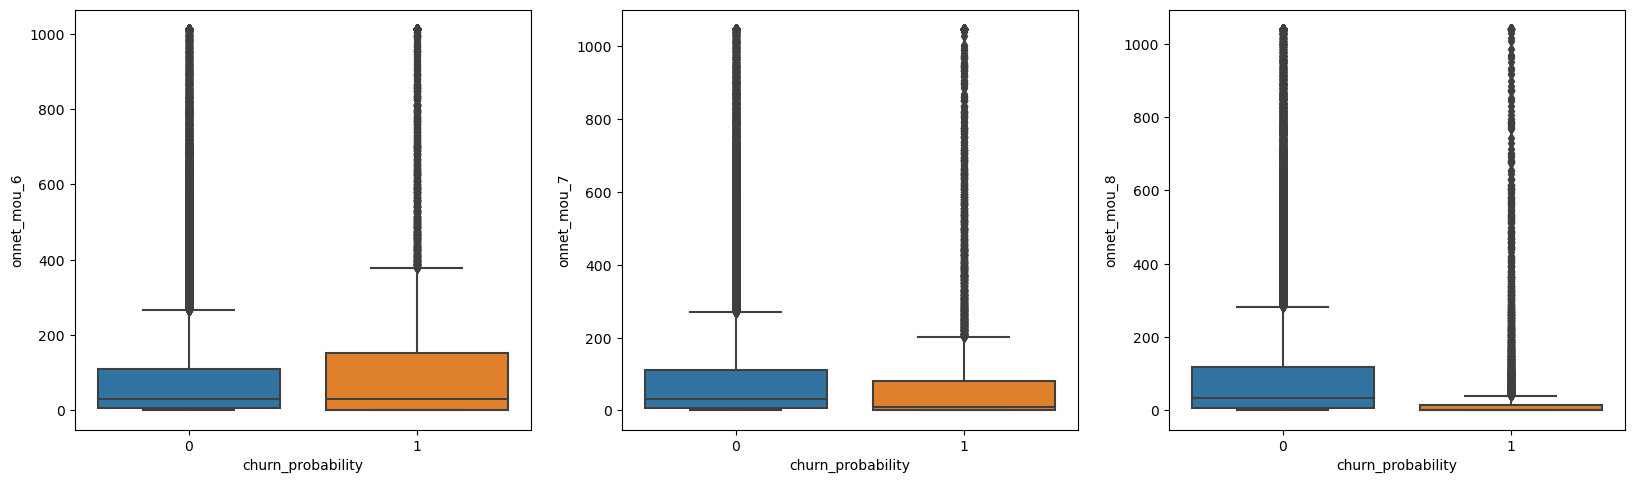

In [374]:
do_box_plot_3(df_train_preprocess,'churn_probability','onnet_mou')

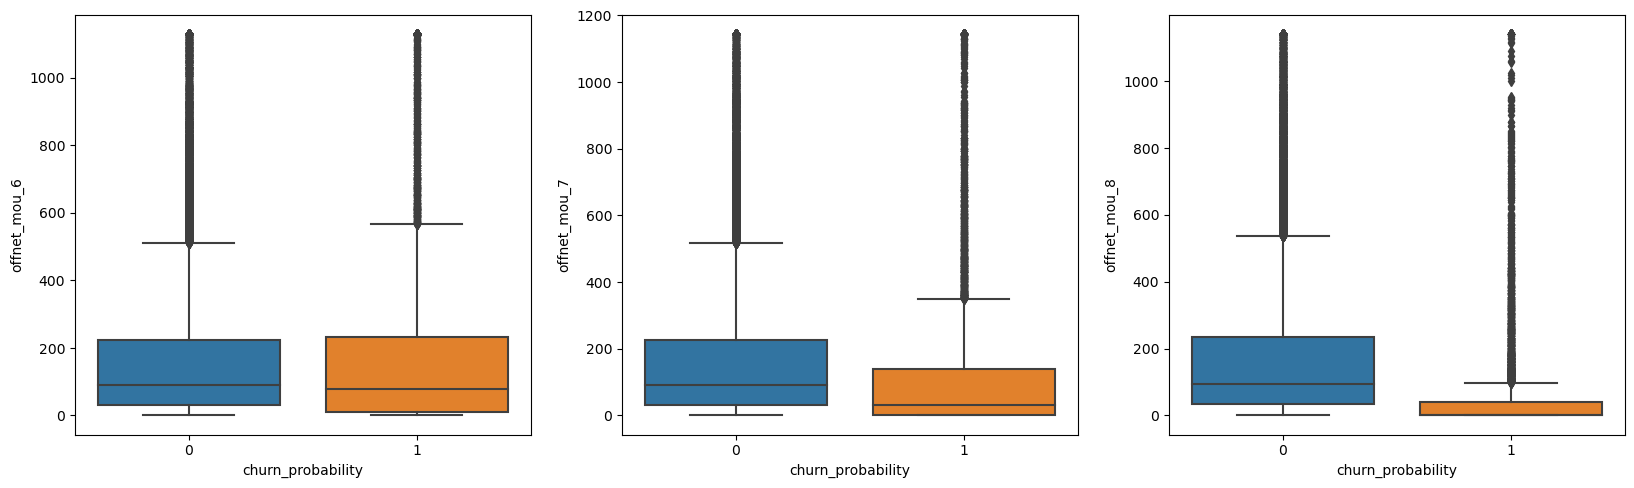

In [375]:
do_box_plot_3(df_train_preprocess,'churn_probability','offnet_mou')

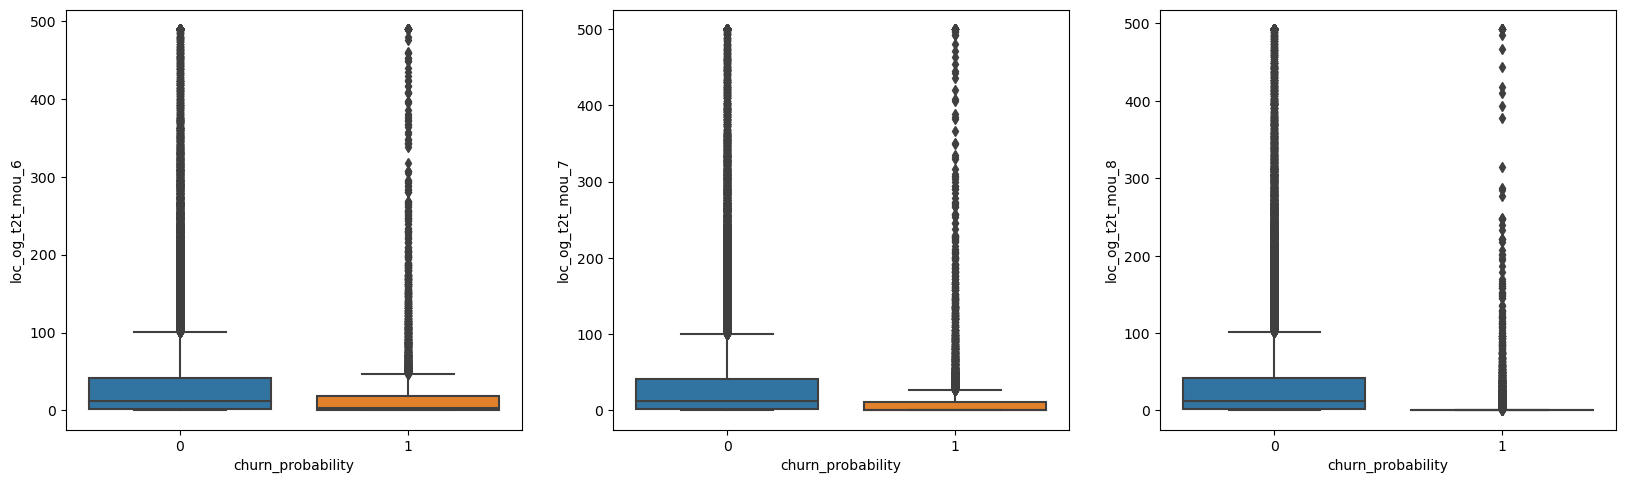

In [376]:
do_box_plot_3(df_train_preprocess,'churn_probability','loc_og_t2t_mou')

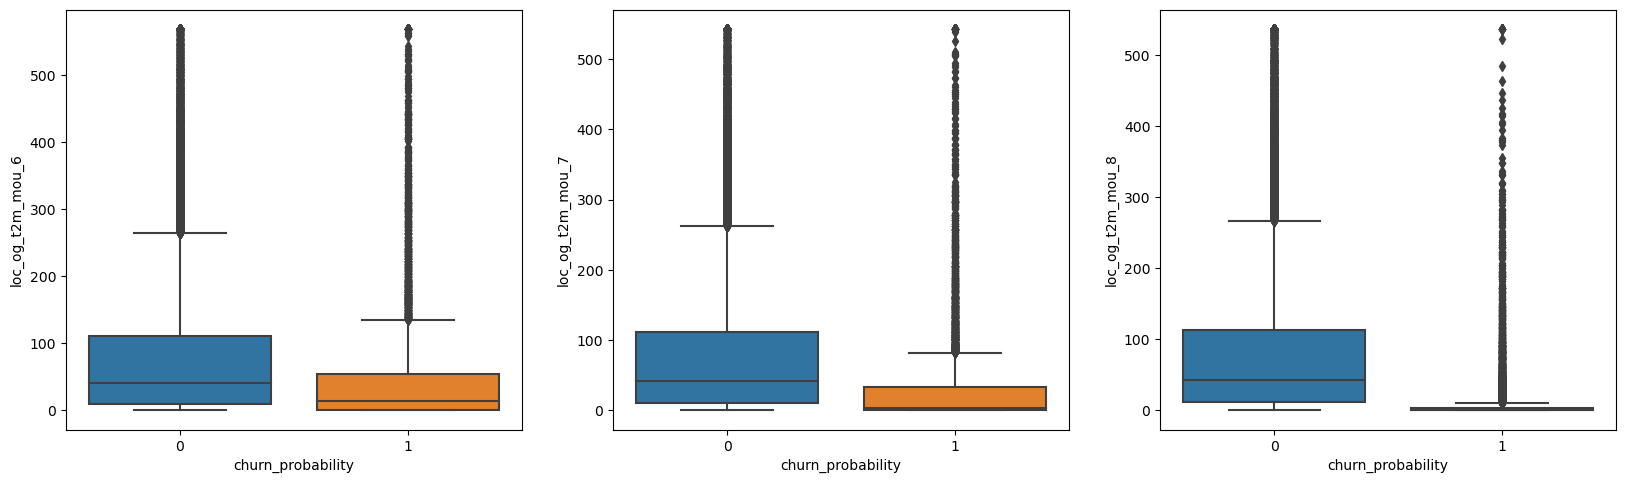

In [377]:
do_box_plot_3(df_train_preprocess,'churn_probability','loc_og_t2m_mou')

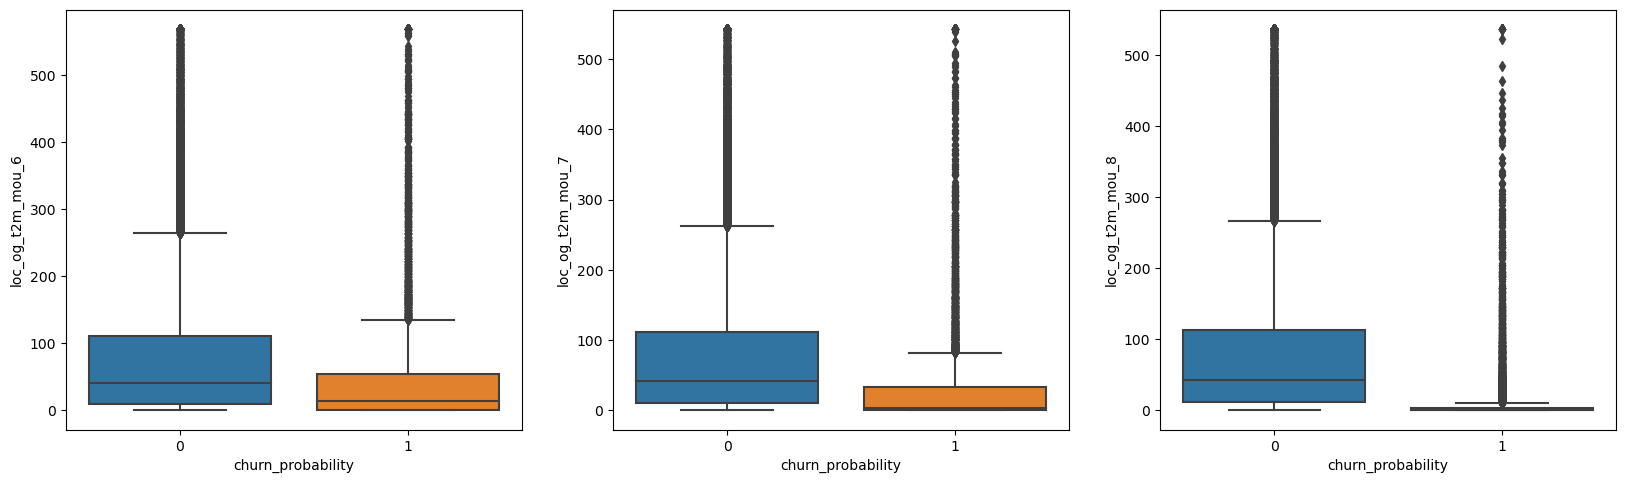

In [378]:
do_box_plot_3(df_train_preprocess,'churn_probability','loc_og_t2m_mou')

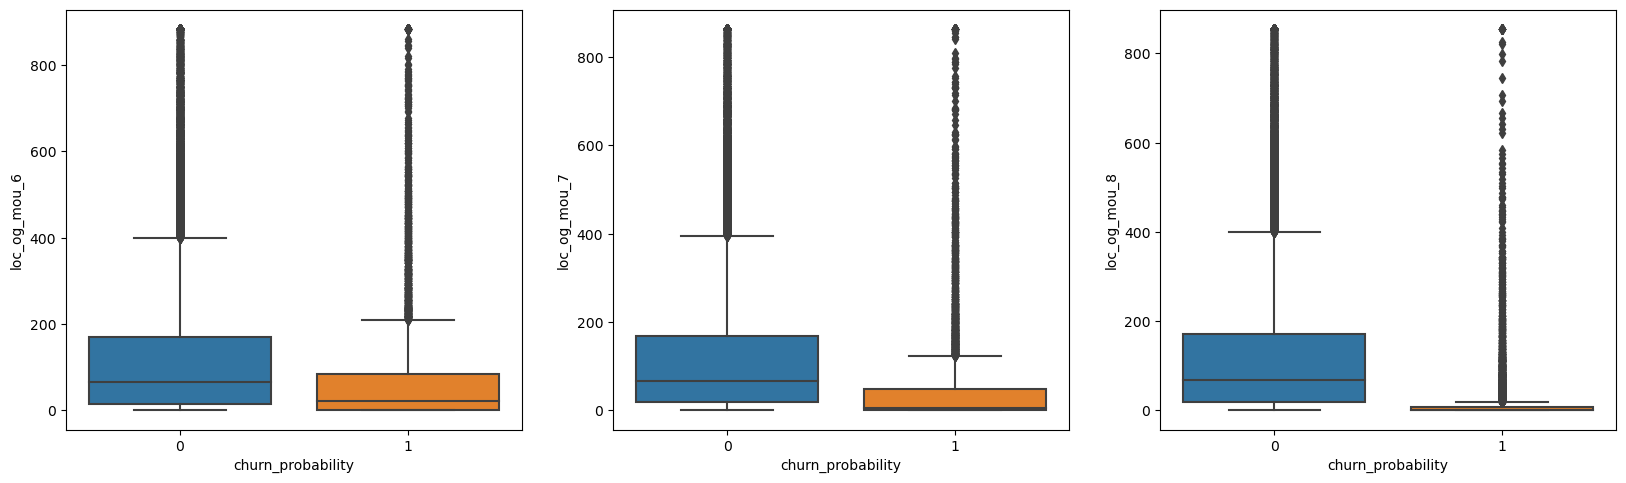

In [379]:
do_box_plot_3(df_train_preprocess,'churn_probability','loc_og_mou')

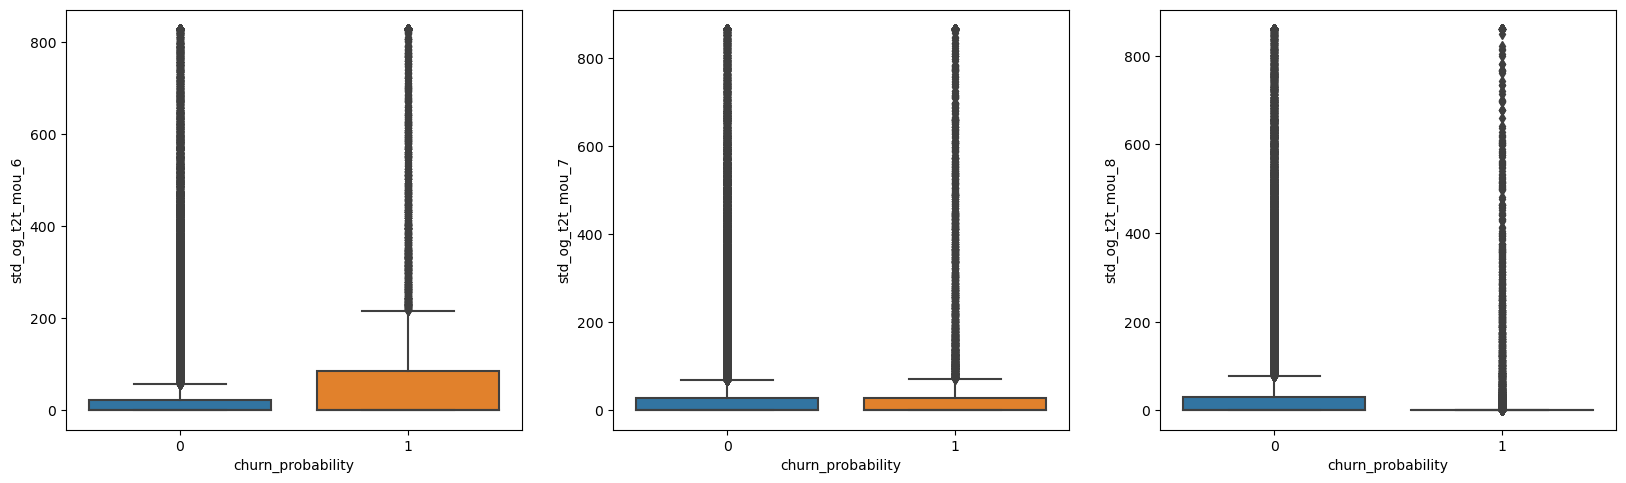

In [380]:
do_box_plot_3(df_train_preprocess,'churn_probability','std_og_t2t_mou')

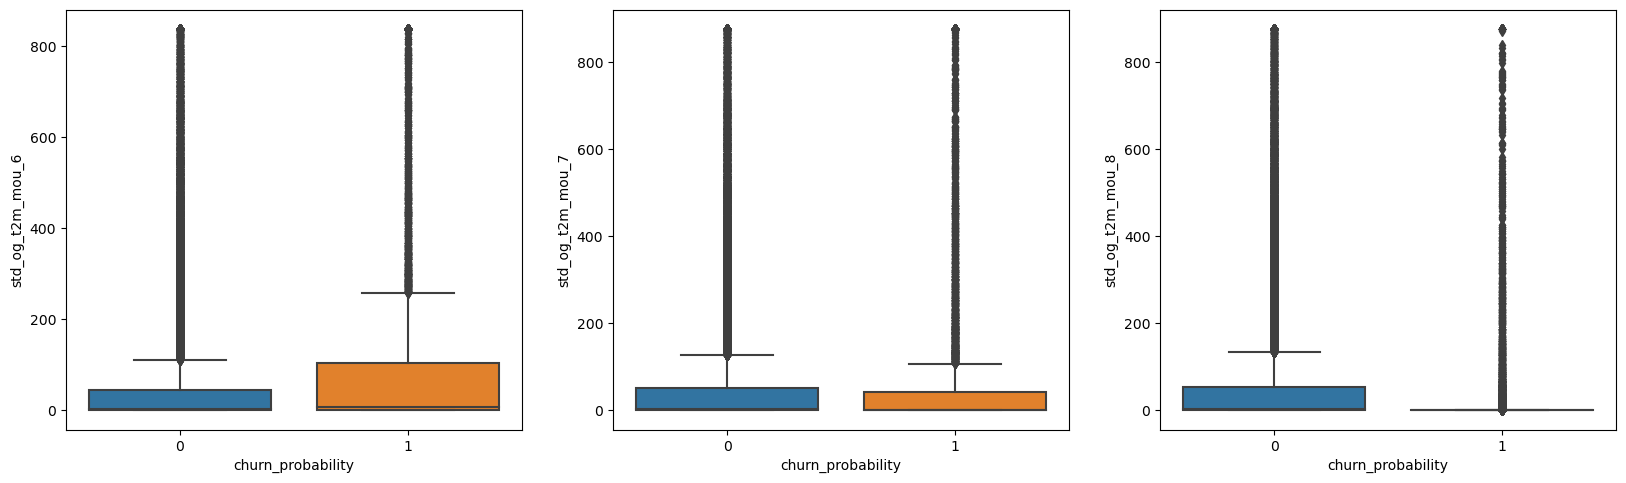

In [381]:
do_box_plot_3(df_train_preprocess,'churn_probability','std_og_t2m_mou')

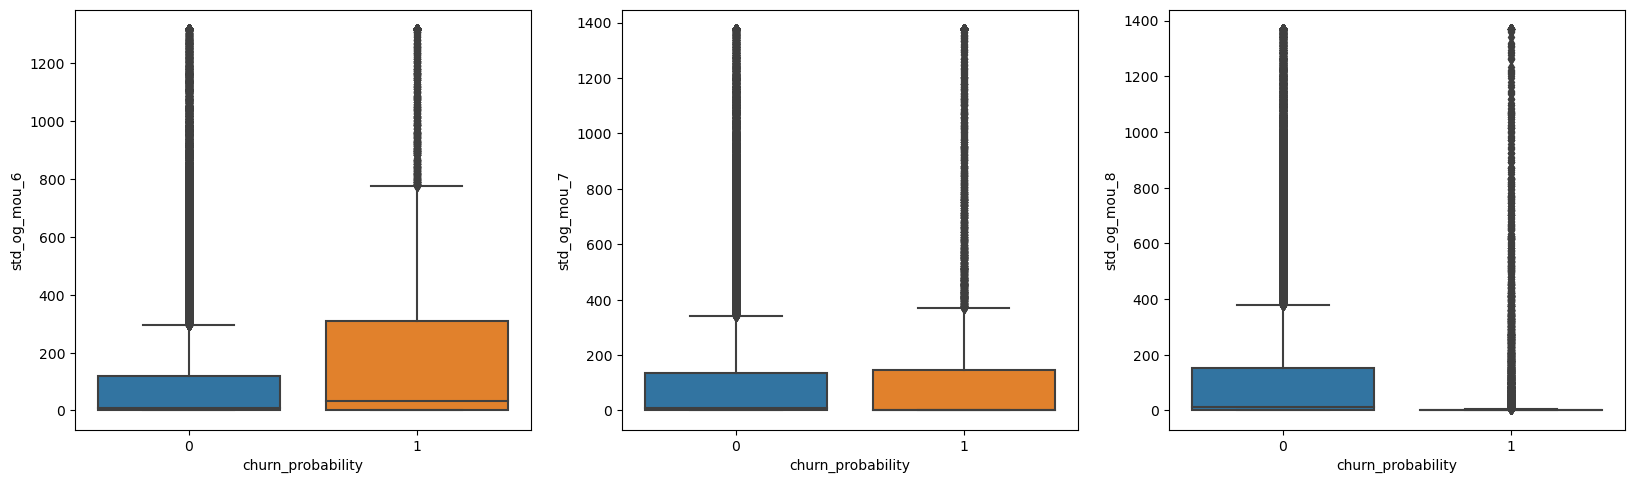

In [382]:
do_box_plot_3(df_train_preprocess,'churn_probability','std_og_mou')

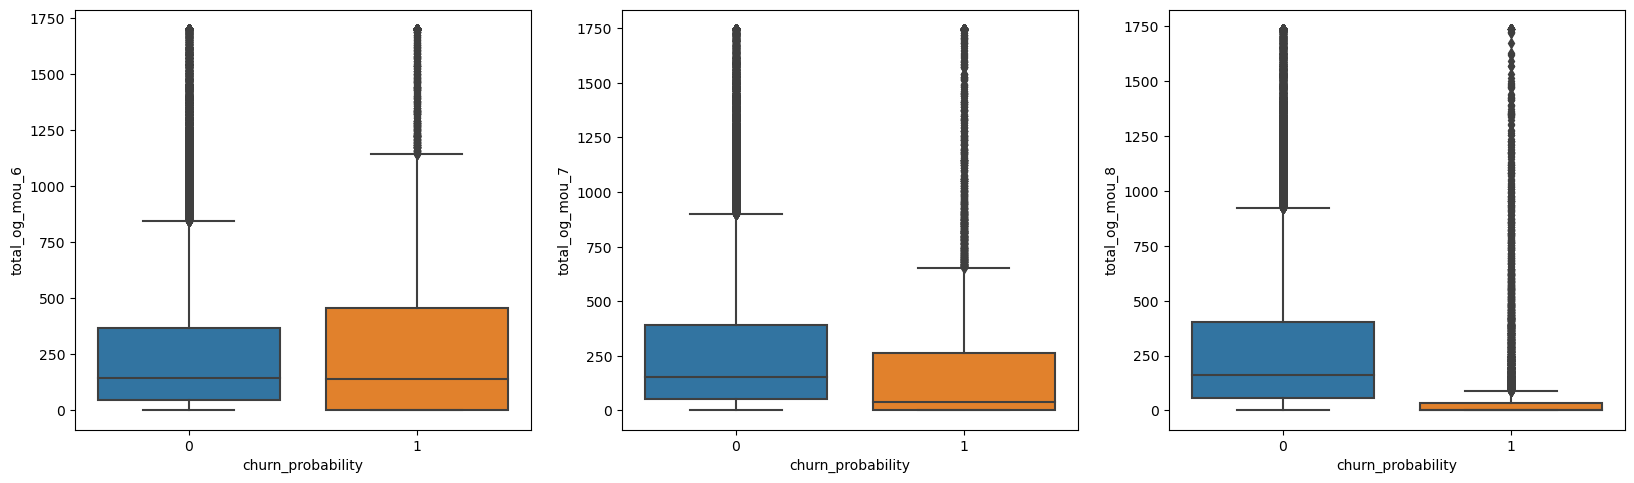

In [383]:
do_box_plot_3(df_train_preprocess,'churn_probability','total_og_mou')

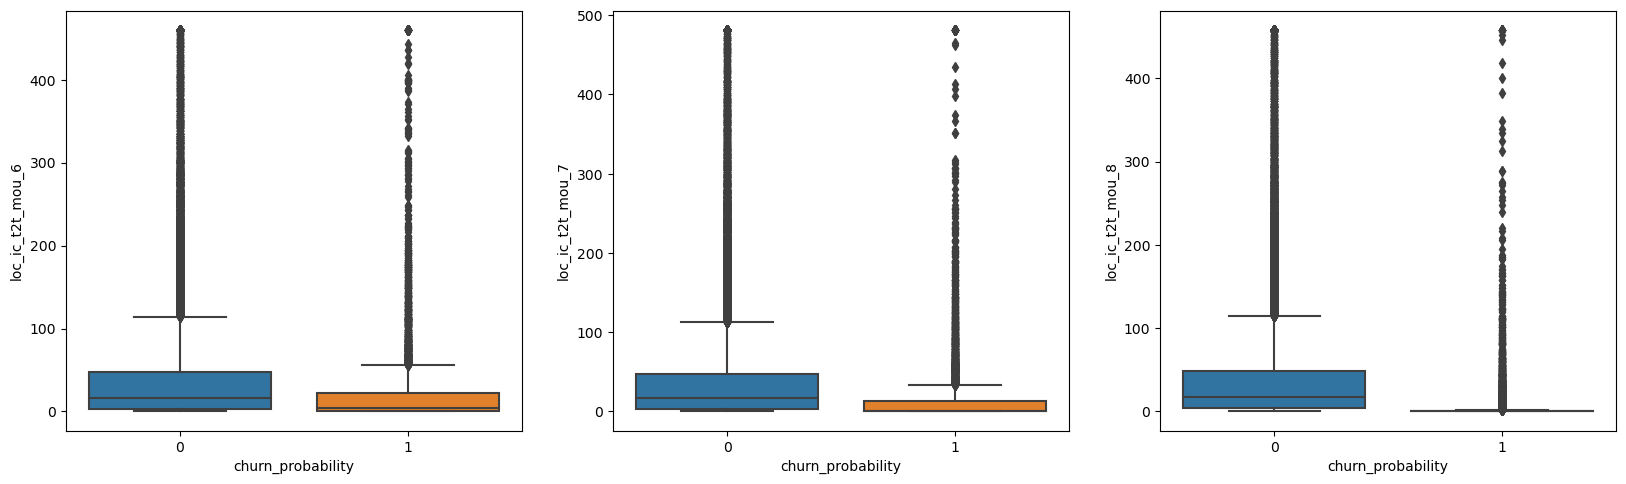

In [384]:
do_box_plot_3(df_train_preprocess,'churn_probability','loc_ic_t2t_mou')

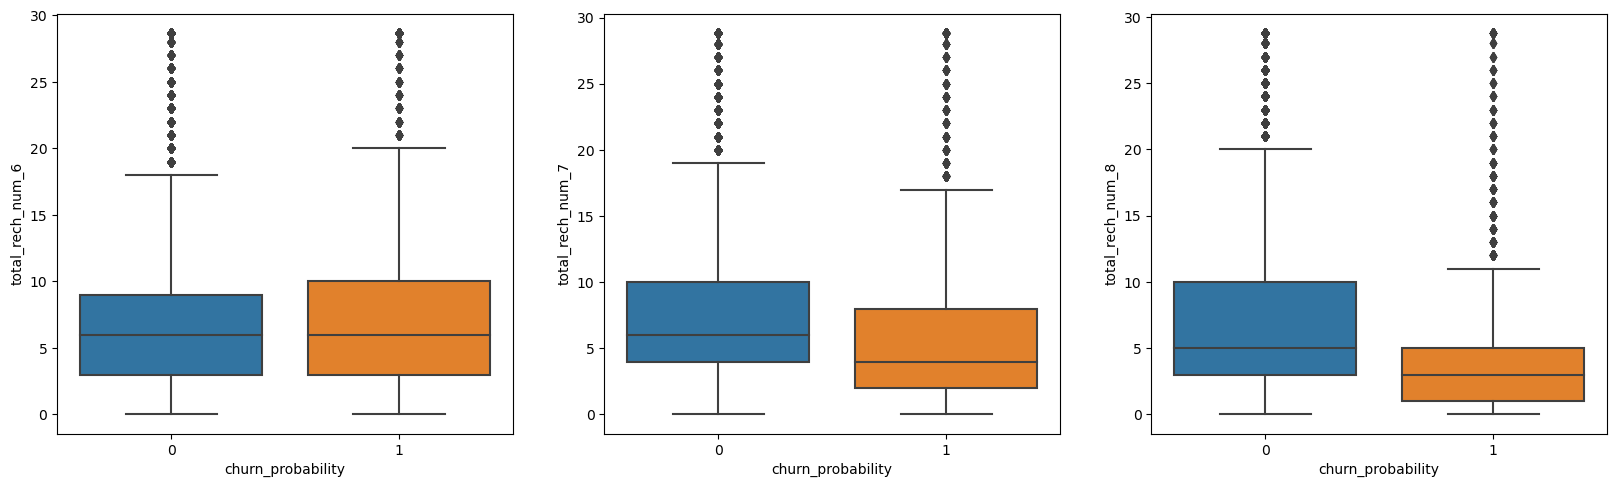

In [385]:
do_box_plot_3(df_train_preprocess,'churn_probability','total_rech_num')

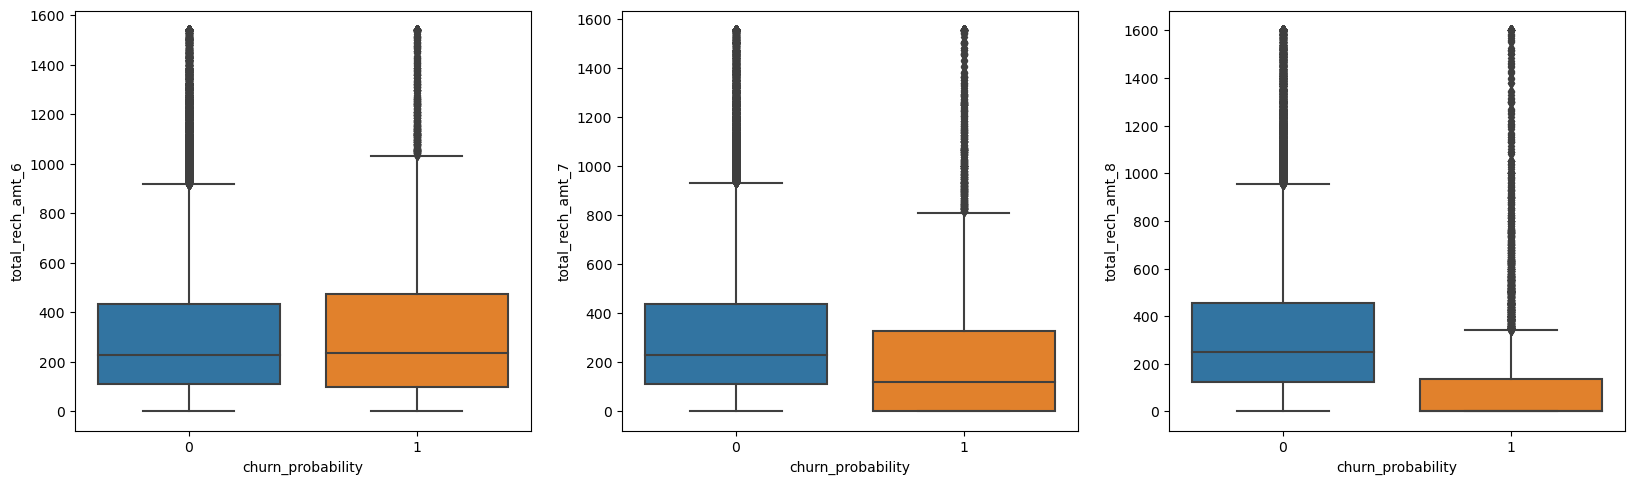

In [386]:
do_box_plot_3(df_train_preprocess,'churn_probability','total_rech_amt')

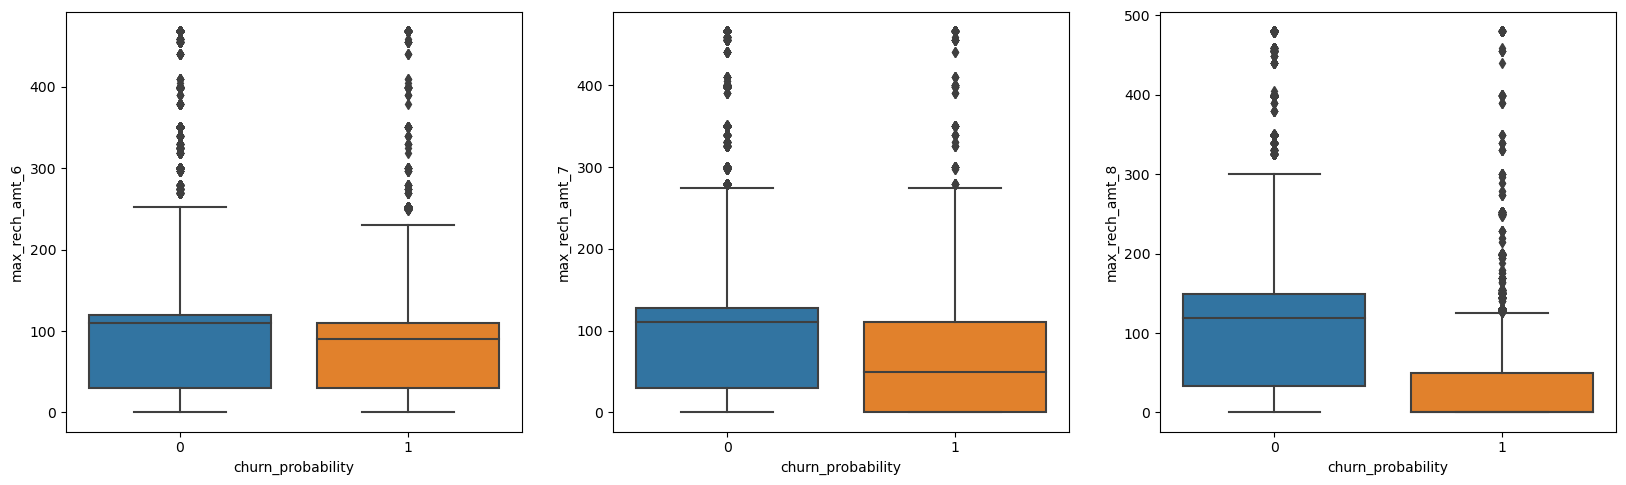

In [387]:
do_box_plot_3(df_train_preprocess,'churn_probability','max_rech_amt')

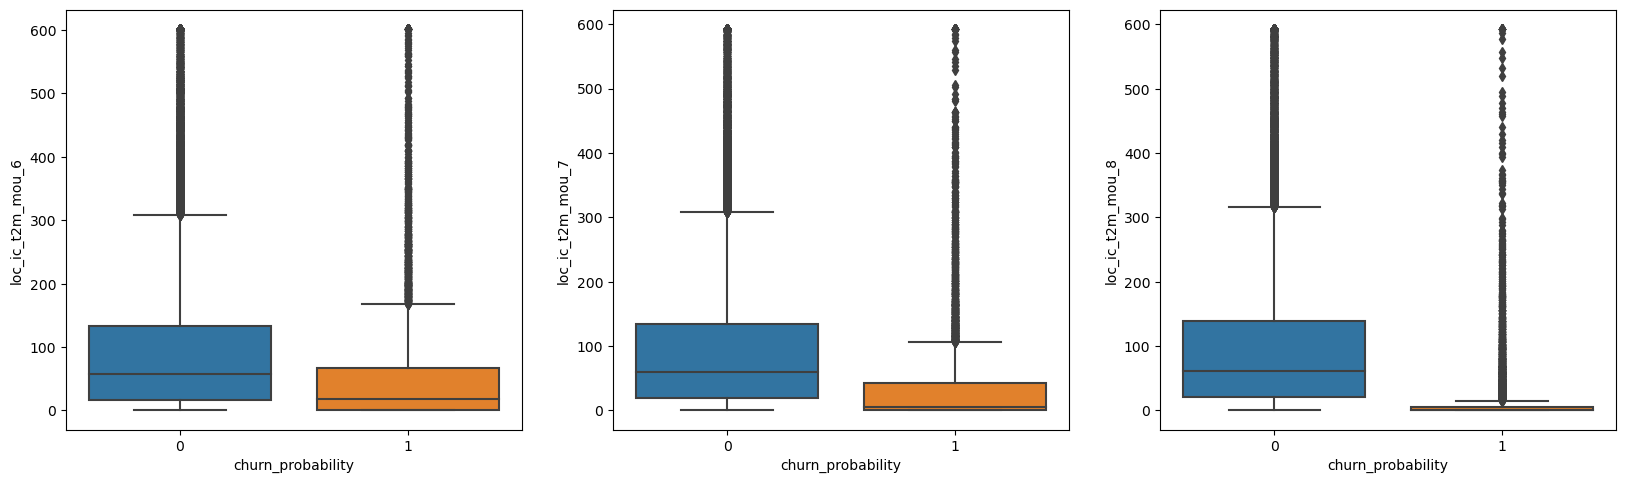

In [388]:
do_box_plot_3(df_train_preprocess,'churn_probability','loc_ic_t2m_mou')

In [389]:
#scaling columns using min max scaler
scaler = MinMaxScaler()

In [390]:
#list of scaled columns 
scaled_columns = [
'arpu_6',
'arpu_7',
'arpu_8',
'onnet_mou_6',
'onnet_mou_7',
'onnet_mou_8',
'offnet_mou_6',
'offnet_mou_7',
'offnet_mou_8',
'roam_ic_mou_6',
'roam_ic_mou_7',
'roam_ic_mou_8',
'roam_og_mou_6',
'roam_og_mou_7',
'roam_og_mou_8',
'loc_og_t2t_mou_6',
'loc_og_t2t_mou_7',
'loc_og_t2t_mou_8',
'loc_og_t2m_mou_6',
'loc_og_t2m_mou_7',
'loc_og_t2m_mou_8',
'loc_og_t2f_mou_6',
'loc_og_t2f_mou_7',
'loc_og_t2f_mou_8',
'loc_og_mou_6',
'loc_og_mou_7',
'loc_og_mou_8',
'std_og_t2t_mou_6',
'std_og_t2t_mou_7',
'std_og_t2t_mou_8',
'std_og_t2m_mou_6',
'std_og_t2m_mou_7',
'std_og_t2m_mou_8',
'std_og_mou_6',
'std_og_mou_7',
'std_og_mou_8',
'spl_og_mou_6',
'spl_og_mou_7',
'spl_og_mou_8',
'total_og_mou_6',
'total_og_mou_7',
'total_og_mou_8',
'loc_ic_t2t_mou_6',
'loc_ic_t2t_mou_7',
'loc_ic_t2t_mou_8',
'loc_ic_t2m_mou_6',
'loc_ic_t2m_mou_7',
'loc_ic_t2m_mou_8',
'loc_ic_t2f_mou_6',
'loc_ic_t2f_mou_7',
'loc_ic_t2f_mou_8',
'loc_ic_mou_6',
'loc_ic_mou_7',
'loc_ic_mou_8',
'std_ic_t2t_mou_6',
'std_ic_t2t_mou_7',
'std_ic_t2t_mou_8',
'std_ic_t2m_mou_6',
'std_ic_t2m_mou_7',
'std_ic_t2m_mou_8',
'total_rech_num_6',
'total_rech_num_7',
'total_rech_num_8',
'total_rech_amt_6',
'total_rech_amt_7',
'total_rech_amt_8',
'max_rech_amt_6',
'max_rech_amt_7',
'max_rech_amt_8',
'last_day_rch_amt_6',
'last_day_rch_amt_7',
'last_day_rch_amt_8',
'aon']


In [391]:
#apply scaler to df_train
df_train_preprocess[scaled_columns] = scaler.fit_transform(df_train_preprocess[scaled_columns])
#df_unseen_preprocess[scaled_columns] = scaler.transform(df_unseen_preprocess[scaled_columns])

###### spliting the train_df


In [392]:
# Doing train_test_split with seed, we specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(df_train_preprocess, train_size = 0.8, test_size = 0.2, random_state = 100)

In [393]:
y_train = df_train.pop('churn_probability')
X_train = df_train

In [394]:
logreg = LogisticRegression()

In [395]:
estimator=logreg
rfe = RFE(estimator=logreg, n_features_to_select=30)             
rfe = rfe.fit(X_train[scaled_columns], y_train)

In [396]:
col = X_train[scaled_columns].columns[rfe.support_]

In [397]:
X_train_sm = sm.add_constant(X_train[scaled_columns][col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()
#lr=train_print_summary(col,X_train,y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                55999
Model:                            GLM   Df Residuals:                    55968
Model Family:                Binomial   Df Model:                           30
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12347.
Date:                Wed, 08 Nov 2023   Deviance:                       24694.
Time:                        19:38:20   Pearson chi2:                 1.31e+07
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1976
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.4691      0.195    -12.683      0.000      -2.851      -2.088
arpu_6                 3.5589      0.441      8.070      0.000       2.694       4.423
arpu_7                 3.3573      0.270     12.432      0.000       2.828       3.887
offnet_mou_8          -1.4801      0.422     -3.507      0.000      -2.307      -0.653
roam_og_mou_8          1.9965      0.118     16.936      0.000       1.765       2.228
loc_og_t2t_mou_8      -2.3183      0.481     -4.820      0.000      -3.261      -1.376
loc_og_t2m_mou_7      -1.5063      0.394     -3.823      0.000      -2.279      -0.734
loc_og_t2m_mou_8       0.0405      0.391      0.104      0.917      -0.726       0.807
loc_og_mou_7           1.0761      0.427      2.522      0.012       0.240       1.912
std_og_t2t_mou_8      -1.5110      0.373     -4.049      0.000      -2.242      -0.780
std_og_mou_8           1.4502      0.485      2.989      0.003       0.499       2.401
spl_og_mou_8          -0.8470      0.171     -4.955      0.000      -1.182      -0.512
loc_ic_t2t_mou_7      -1.7725      0.535     -3.314      0.001      -2.821      -0.724
loc_ic_t2t_mou_8      -7.8348      0.940     -8.339      0.000      -9.676      -5.993
loc_ic_t2m_mou_7      -1.4696      0.566     -2.597      0.009      -2.579      -0.360
loc_ic_t2m_mou_8     -12.5022      0.885    -14.132      0.000     -14.236     -10.768
loc_ic_t2f_mou_8      -4.6915      0.414    -11.318      0.000      -5.504      -3.879
loc_ic_mou_6           0.6190      0.169      3.665      0.000       0.288       0.950
loc_ic_mou_7           3.2158      0.767      4.194      0.000       1.713       4.719
loc_ic_mou_8           6.1373      1.221      5.027      0.000       3.745       8.530
std_ic_t2t_mou_7       0.6277      0.190      3.304      0.001       0.255       1.000
std_ic_t2t_mou_8      -0.8480      0.260     -3.265      0.001      -1.357      -0.339
std_ic_t2m_mou_8      -1.3277      0.216     -6.155      0.000      -1.751      -0.905
total_rech_num_8      -5.1147      0.185    -27.645      0.000      -5.477      -4.752
total_rech_amt_6      -1.1812      0.284     -4.161      0.000      -1.738      -0.625
total_rech_amt_8       2.1058      0.299      7.050      0.000       1.520       2.691
max_rech_amt_7        -1.2448      0.140     -8.872      0.000      -1.520      -0.970
max_rech_amt_8        -2.5301      0.182    -13.870      0.000      -2.888      -2.173
last_day_rch_amt_7    -0.4760      0.124     -3.843      0.000      -0.719      -0.233
last_day_rch_amt_8    -2.8059      0.169    -16.646      0.000      -3.136      -2.476
aon                   -1.1308      0.088    -12.868      0.000      -1.303      -0.959
======================================================================================
"""

In [398]:
vif_print_summary(col,X_train)

              Features    VIF
18        loc_ic_mou_8  78.72
17        loc_ic_mou_7  59.31
0               arpu_6  56.50
1               arpu_7  52.58
14    loc_ic_t2m_mou_8  44.02
13    loc_ic_t2m_mou_7  34.16
9         std_og_mou_8  24.03
2         offnet_mou_8  20.15
7         loc_og_mou_7  18.98
5     loc_og_t2m_mou_7  17.91
12    loc_ic_t2t_mou_8  14.81
6     loc_og_t2m_mou_8  12.58
24    total_rech_amt_8  12.19
11    loc_ic_t2t_mou_7  11.87
8     std_og_t2t_mou_8  10.36
23    total_rech_amt_6   7.48
26      max_rech_amt_8   6.59
16        loc_ic_mou_6   6.07
22    total_rech_num_8   5.39
25      max_rech_amt_7   5.03
4     loc_og_t2t_mou_8   4.18
28  last_day_rch_amt_8   3.01
27  last_day_rch_amt_7   2.78
29                 aon   2.51
15    loc_ic_t2f_mou_8   2.37
20    std_ic_t2t_mou_8   2.33
19    std_ic_t2t_mou_7   2.24
21    std_ic_t2m_mou_8   1.47
10        spl_og_mou_8   1.36
3        roam_og_mou_8   1.31


In [399]:
col = col.drop('loc_ic_mou_8', 1)
col = col.drop('loc_ic_mou_7', 1)
col = col.drop('arpu_6', 1)
col = col.drop('arpu_7', 1)
col = col.drop('loc_ic_t2m_mou_8', 1)
col = col.drop('loc_ic_t2m_mou_7', 1)
col = col.drop('loc_og_mou_7', 1)
col = col.drop('loc_og_t2m_mou_7', 1)
col = col.drop('loc_ic_t2t_mou_8', 1)
col = col.drop('loc_og_t2m_mou_8', 1)
col = col.drop('total_rech_amt_8', 1)
col = col.drop('loc_ic_t2t_mou_7', 1)
col = col.drop('std_og_t2t_mou_8', 1)
col

Index(['offnet_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'std_og_mou_8',
       'spl_og_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_6', 'std_ic_t2t_mou_7',
       'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'total_rech_num_8',
       'total_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'last_day_rch_amt_7', 'last_day_rch_amt_8', 'aon'],
      dtype='object')

In [400]:
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()


#lr=train_print_summary(col,X_train,y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                55999
Model:                            GLM   Df Residuals:                    55981
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13148.
Date:                Wed, 08 Nov 2023   Deviance:                       26295.
Time:                        19:38:27   Pearson chi2:                 1.40e+06
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1743
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0801      0.037     -2.193      0.028      -0.152      -0.009
offnet_mou_8          -1.1799      0.194     -6.086      0.000      -1.560      -0.800
roam_og_mou_8          2.8920      0.099     29.121      0.000       2.697       3.087
loc_og_t2t_mou_8      -6.7711      0.522    -12.964      0.000      -7.795      -5.747
std_og_mou_8           1.3540      0.153      8.860      0.000       1.054       1.654
spl_og_mou_8          -1.1222      0.174     -6.446      0.000      -1.463      -0.781
loc_ic_t2f_mou_8      -5.7747      0.421    -13.719      0.000      -6.600      -4.950
loc_ic_mou_6          -0.9455      0.118     -8.018      0.000      -1.177      -0.714
std_ic_t2t_mou_7       1.1743      0.182      6.460      0.000       0.818       1.531
std_ic_t2t_mou_8      -1.9480      0.273     -7.140      0.000      -2.483      -1.413
std_ic_t2m_mou_8      -1.9285      0.229     -8.418      0.000      -2.378      -1.479
total_rech_num_8      -5.1067      0.160    -32.014      0.000      -5.419      -4.794
total_rech_amt_6       2.1812      0.094     23.094      0.000       1.996       2.366
max_rech_amt_7        -0.4271      0.123     -3.463      0.001      -0.669      -0.185
max_rech_amt_8        -2.2741      0.149    -15.239      0.000      -2.567      -1.982
last_day_rch_amt_7    -0.5620      0.120     -4.699      0.000      -0.796      -0.328
last_day_rch_amt_8    -2.9931      0.167    -17.873      0.000      -3.321      -2.665
aon                   -1.4717      0.086    -17.162      0.000      -1.640      -1.304
======================================================================================
"""

In [401]:
vif_print_summary(col,X_train)


              Features   VIF
13      max_rech_amt_8  4.75
12      max_rech_amt_7  4.40
0         offnet_mou_8  3.47
11    total_rech_amt_6  3.01
15  last_day_rch_amt_8  2.89
14  last_day_rch_amt_7  2.73
3         std_og_mou_8  2.67
10    total_rech_num_8  2.65
6         loc_ic_mou_6  2.44
8     std_ic_t2t_mou_8  2.29
7     std_ic_t2t_mou_7  2.21
16                 aon  2.05
2     loc_og_t2t_mou_8  1.61
5     loc_ic_t2f_mou_8  1.45
9     std_ic_t2m_mou_8  1.43
4         spl_og_mou_8  1.33
1        roam_og_mou_8  1.14


In [402]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

In [403]:
y_train_pred

array([3.40661674e-01, 1.36619332e-03, 9.39295093e-03, ...,
       2.71546060e-02, 8.78508868e-03, 5.18781758e-07])

In [404]:
y_train_pred.shape

(55999,)

In [405]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['id'] = y_train.index

In [406]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.3 else 0)

# Let's see the head
y_train_pred_final.head()

Churn  Churn_Prob     id  predicted
0      1    0.340662  59805          1
1      0    0.001366  32717          0
2      0    0.009393   5964          0
3      0    0.022363  47623          0
4      0    0.032302  31881          0

In [407]:
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.9066054750977696


In [408]:
# Let's take a look at the confusion matrix.
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
confusion

array([[47383,  2876],
       [ 2354,  3386]], dtype=int64)

In [409]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [410]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.5898954703832753

In [411]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.05722358184603753


In [412]:
# positive predictive value 
print (TP / float(TP+FP))

0.5407218141168956


In [413]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9526710497215353


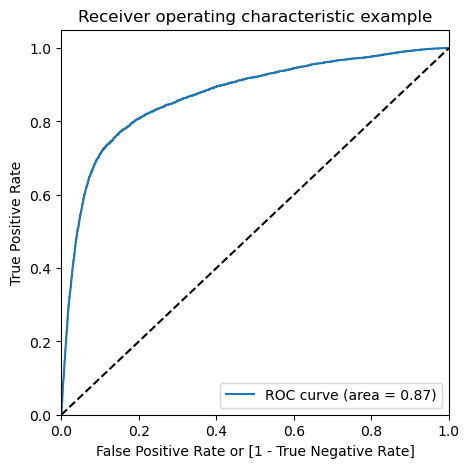

In [414]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

In [415]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Churn  Churn_Prob     id  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
0      1    0.340662  59805          1    1    1    1    1    0    0    0   
1      0    0.001366  32717          0    1    0    0    0    0    0    0   
2      0    0.009393   5964          0    1    0    0    0    0    0    0   
3      0    0.022363  47623          0    1    0    0    0    0    0    0   
4      0    0.032302  31881          0    1    0    0    0    0    0    0   

   0.7  0.8  0.9  
0    0    0    0  
1    0    0    0  
2    0    0    0  
3    0    0    0  
4    0    0    0

In [416]:

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])




# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.102502  1.000000  0.000000
0.1   0.1  0.764085  0.832056  0.756322
0.2   0.2  0.873301  0.726307  0.890089
0.3   0.3  0.906605  0.589895  0.942776
0.4   0.4  0.912606  0.401220  0.971010
0.5   0.5  0.907355  0.198432  0.988320
0.6   0.6  0.902320  0.085366  0.995623
0.7   0.7  0.899337  0.035366  0.998010
0.8   0.8  0.898141  0.012195  0.999324
0.9   0.9  0.897534  0.001742  0.999841


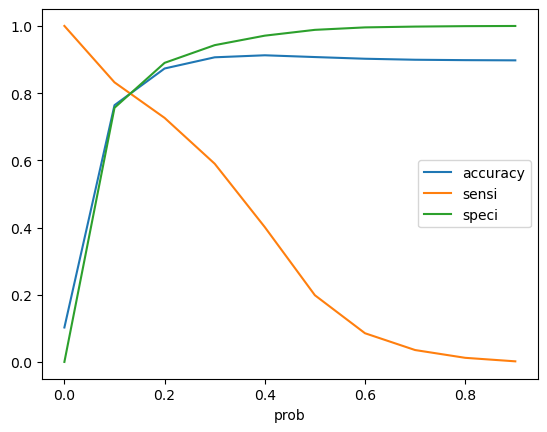

In [417]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [418]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.18 else 0)

y_train_pred_final.head()

Churn  Churn_Prob     id  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
0      1    0.340662  59805          1    1    1    1    1    0    0    0   
1      0    0.001366  32717          0    1    0    0    0    0    0    0   
2      0    0.009393   5964          0    1    0    0    0    0    0    0   
3      0    0.022363  47623          0    1    0    0    0    0    0    0   
4      0    0.032302  31881          0    1    0    0    0    0    0    0   

   0.7  0.8  0.9  final_predicted  
0    0    0    0                1  
1    0    0    0                0  
2    0    0    0                0  
3    0    0    0                0  
4    0    0    0                0

In [419]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.final_predicted )
confusion2

array([[43844,  6415],
       [ 1461,  4279]], dtype=int64)

In [420]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [421]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7454703832752613

In [422]:
# Let us calculate specificity
TN / float(TN+FP)

0.8723611691438349

In [423]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.12763883085616506


In [424]:
# Positive predictive value 
print (TP / float(TP+FP))

0.400130914531513


In [425]:
#Precision
#TP / TP + FP
confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.5407218141168956

In [426]:
#Recall
#TP / TP + FN
confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.5898954703832753

In [427]:
precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.5407218141168956

In [428]:
recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.5898954703832753

In [429]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

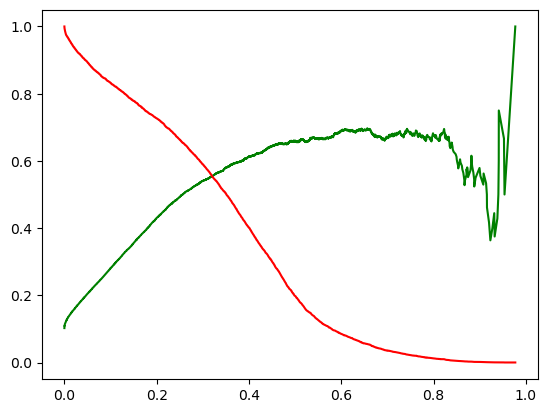

In [430]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

###### Preform prediction on test data

In [431]:
#get X and y data set to train the model 
y_test = df_test.pop('churn_probability')
X_test = df_test

In [432]:
X_test = df_test[col]
#X_test.head()

In [433]:
X_test_sm = sm.add_constant(X_test)

In [434]:
y_test_pred = res.predict(X_test_sm)

In [435]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [436]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [437]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [438]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob_predicted_model'})

In [439]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob_predicted_model.map(lambda x: 1 if x > 0.2 else 0)

In [440]:

# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.churn_probability, y_pred_final.final_predicted)

0.8742857142857143

In [441]:
confusion2 = metrics.confusion_matrix(y_pred_final.churn_probability, y_pred_final.final_predicted )
confusion2

array([[11245,  1363],
       [  397,   995]], dtype=int64)

In [442]:

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [443]:

# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7147988505747126

In [444]:
# Let us calculate specificity
TN / float(TN+FP)

0.891894035532995

###### Perform prediction on unseen data

In [445]:
X_unseen = sm.add_constant(df_unseen_preprocess[col])

In [446]:
X_unseen_sm = sm.add_constant(X_unseen)

In [447]:
X_unseen_pred = res.predict(X_unseen_sm)

In [448]:
X_unseen_pred_1 = pd.DataFrame(X_unseen_pred)

In [449]:
# Renaming the column 
X_unseen_pred_1= X_unseen_pred_1.rename(columns={ 0 : 'ch_prob'})

In [450]:
X_unseen_pred_1['churn_probability'] = X_unseen_pred_1.ch_prob.map(lambda x: 1 if x > 0.2 else 0)

In [451]:
X_unseen_pred_1.head()

ch_prob  churn_probability
0   0.000000e+00                  0
1   0.000000e+00                  0
2  1.709856e-256                  0
3   0.000000e+00                  0
4   1.786962e-47                  0

In [452]:
# Appending y_test_df and y_pred_1
kaggle_pred_final = pd.concat([df_unseen_preprocess['id'], X_unseen_pred_1[['ch_prob','churn_probability']]],axis=1)

In [453]:
kaggle_pred_final.head()

id        ch_prob  churn_probability
0  69999   0.000000e+00                  0
1  70000   0.000000e+00                  0
2  70001  1.709856e-256                  0
3  70002   0.000000e+00                  0
4  70003   1.786962e-47                  0

In [454]:
kaggle_pred_final.to_csv('KedarLachke_PreetiShrivastava.csv', index=False)

# Random Forest

In [455]:
from sklearn.ensemble import RandomForestClassifier
# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz
from sklearn.metrics import confusion_matrix, accuracy_score

In [456]:
def get_dt_graph(dt_classifier):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True,
                    feature_names=X_train.columns, 
                    class_names=['Churn', "No Churn"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))

In [457]:
# Doing train_test_split with seed, we specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(df_train_preprocess, train_size = 0.8, test_size = 0.2, random_state = 100)

In [458]:
y_train = df_train.pop('churn_probability')
X_train = df_train
y_test = df_test.pop('churn_probability')
X_test = df_test

In [459]:
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=3)

In [460]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=42)

In [461]:
rf.estimators_[0]

DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1608637542)

In [462]:
sample_tree = rf.estimators_[4]

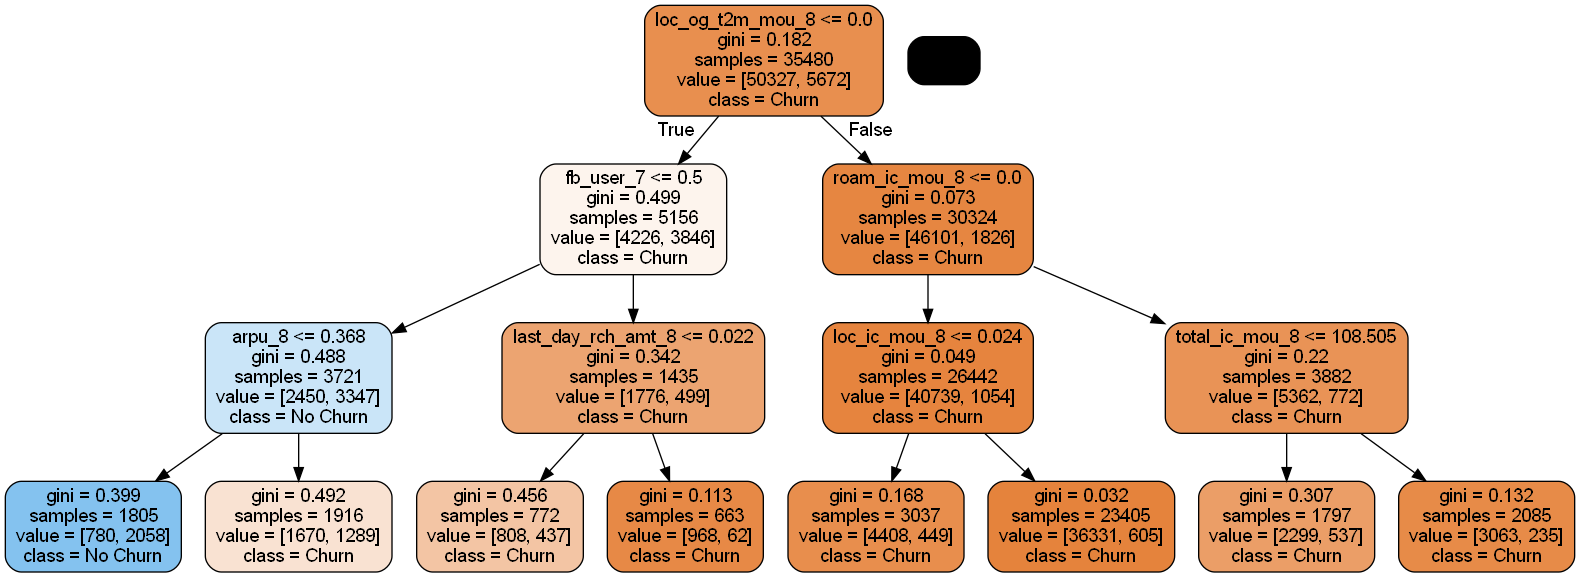

In [463]:
gph = get_dt_graph(sample_tree)
Image(gph.create_png(), width=700, height=700)

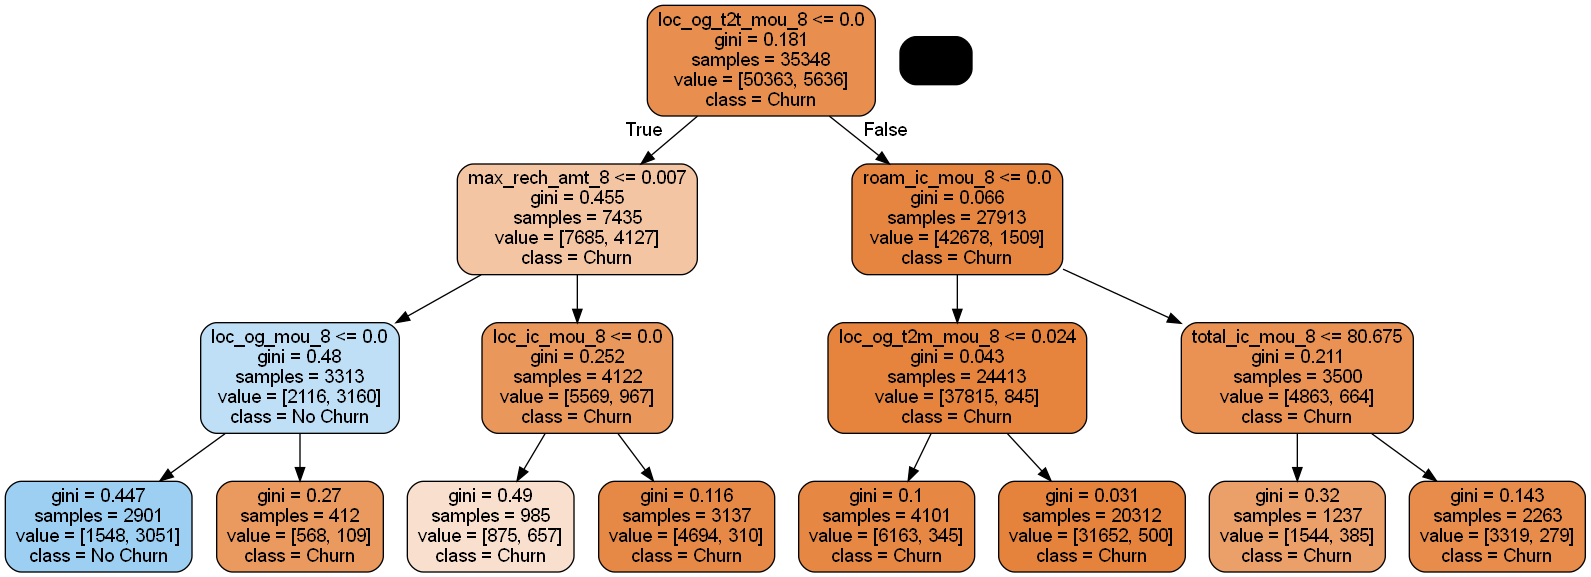

In [464]:
gph = get_dt_graph(rf.estimators_[2])
Image(gph.create_png(), width=700, height=700)

In [465]:
evaluate_model(rf)

Train Accuracy : 0.9406775120984303
Train Confusion Matrix:
[[49359   900]
 [ 2422  3318]]
--------------------------------------------------
Test Accuracy : 0.9438571428571428
Test Confusion Matrix:
[[12416   192]
 [  594   798]]


In [466]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [467]:
params = {
    'max_depth': [ 7 ],
    'min_samples_leaf': [400,600,700],
    'max_features': [6,7],
    'n_estimators': [ 50, 100,200]
}

In [468]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [469]:
%%time
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
CPU times: total: 19.2 s
Wall time: 5min 59s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [7], 'max_features': [6, 7],
                         'min_samples_leaf': [400, 600, 700],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [470]:
rf_best = grid_search.best_estimator_

In [471]:
X_train.shape

(55999, 161)

In [472]:
evaluate_model(rf_best)

Train Accuracy : 0.940802514330613
Train Confusion Matrix:
[[49342   917]
 [ 2398  3342]]
--------------------------------------------------
Test Accuracy : 0.9445
Test Confusion Matrix:
[[12418   190]
 [  587   805]]


In [473]:
sample_tree = rf_best.estimators_[0]

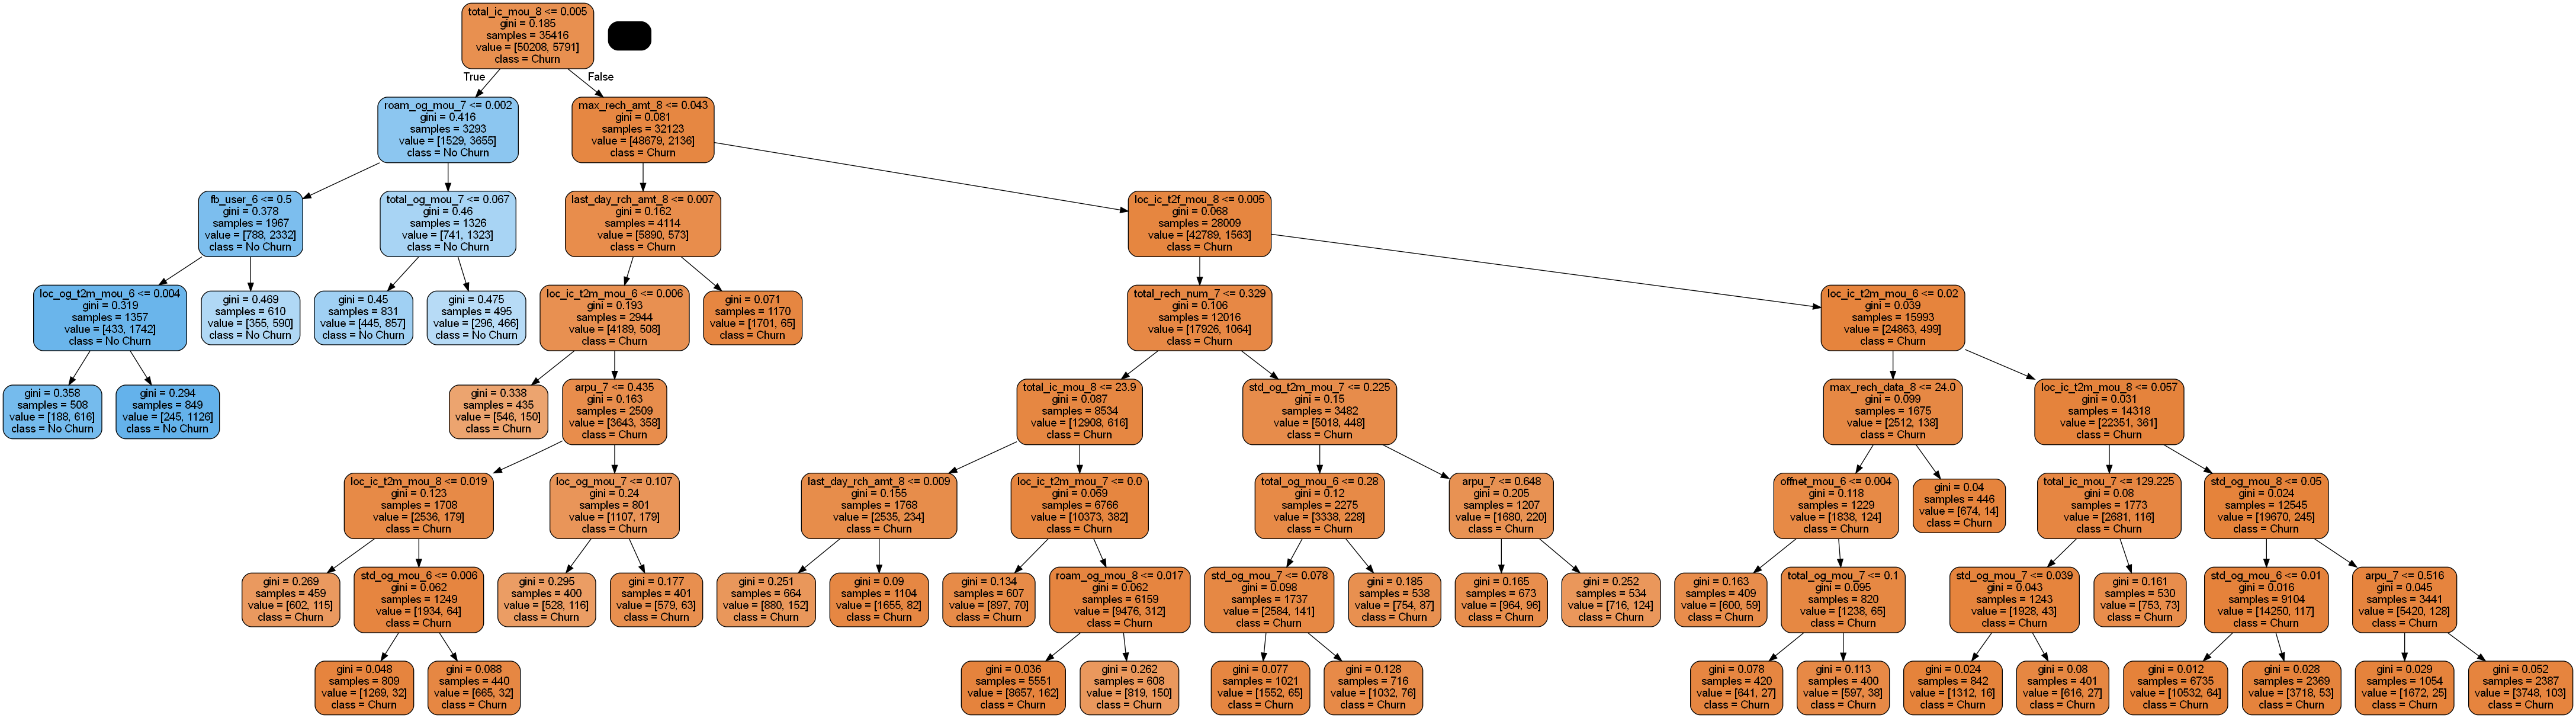

In [474]:
gph = get_dt_graph(sample_tree)
Image(gph.create_png())

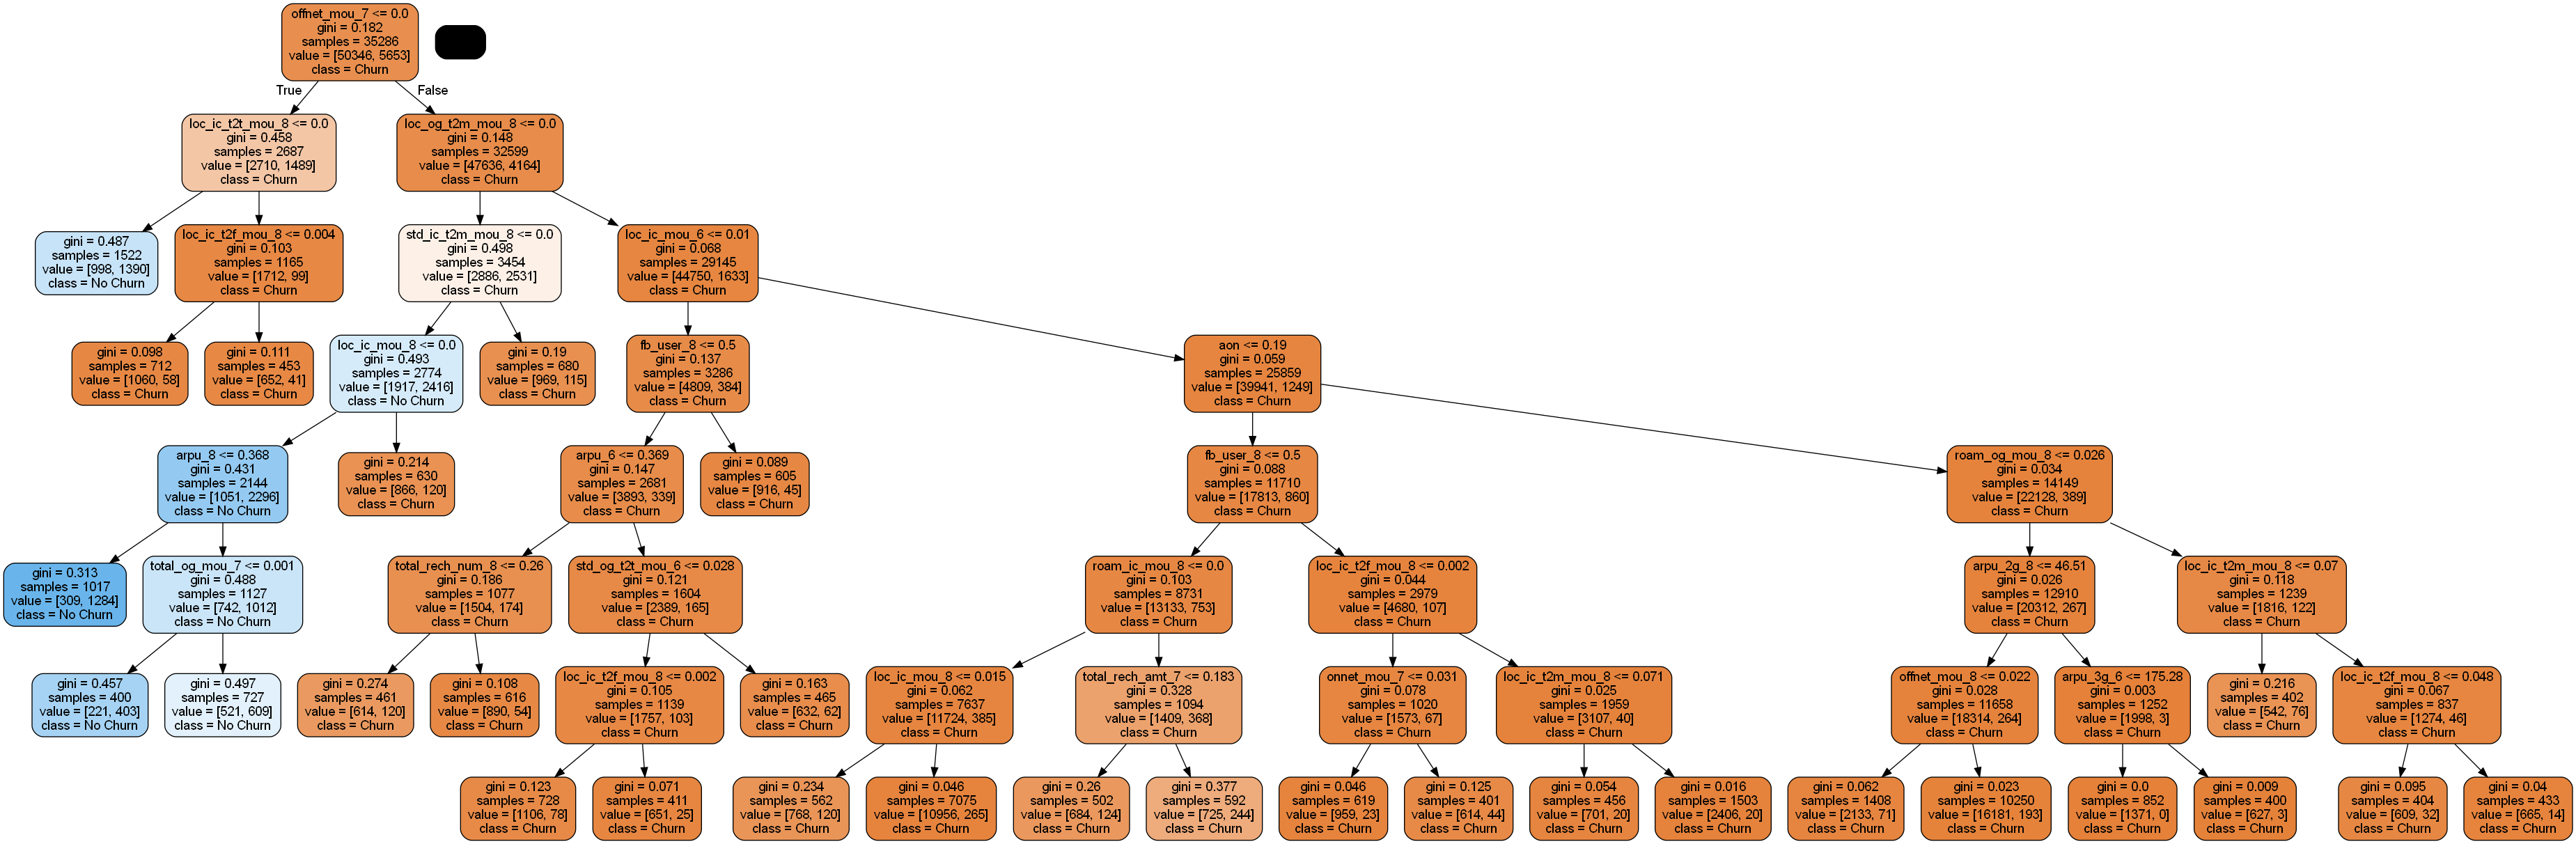

In [475]:
gph = get_dt_graph(rf_best.estimators_[10])
Image(gph.create_png(), height=600, width=600)

In [476]:
rf_best_unseen=rf_best.predict(df_unseen_preprocess)

In [477]:
rf_best_unseen_1 = pd.DataFrame(rf_best_unseen)

rf_best_unseen_1.head()

rf_best_unseen_1= rf_best_unseen_1.rename(columns={ 0 : 'churn_probability'})

In [478]:
# Appending y_test_df and y_pred_1
random_forest_pred_final = pd.concat([df_unseen_preprocess['id'], rf_best_unseen_1['churn_probability']],axis=1)

In [479]:
random_forest_pred_final.to_csv('KedarLachke_PreetiShrivastava_1.csv', index=False)

In [480]:
rf_depth_unseen=rf_best.predict(df_unseen_preprocess)
rf_depth_unseen_1 = pd.DataFrame(rf_depth_unseen)

rf_depth_unseen_1.head()

rf_depth_unseen_1= rf_depth_unseen_1.rename(columns={ 0 : 'churn_probability'})
# Appending y_test_df and y_pred_1
rf_depth_unseen_pred_final = pd.concat([df_unseen_preprocess['id'], rf_depth_unseen_1['churn_probability']],axis=1)
rf_depth_unseen_pred_final.to_csv('test_depth.csv', index=False)

In [481]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, n_estimators=100, oob_score=True)

In [482]:
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [483]:
classifier_rf.feature_importances_

array([2.33738044e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.18835958e-03, 1.88656689e-03, 6.22457296e-02, 3.79595583e-04,
       6.76462023e-04, 1.27318997e-02, 1.39582121e-04, 3.32157931e-03,
       2.25444479e-02, 6.81336954e-05, 1.85969055e-03, 7.62255620e-03,
       3.87831248e-04, 1.85566659e-03, 8.91414730e-03, 1.72624689e-04,
       3.45341698e-03, 3.34107718e-02, 3.54591820e-04, 3.06471286e-03,
       5.05560345e-02, 1.08787590e-04, 4.69541568e-05, 1.48147246e-03,
       4.00029342e-05, 1.24349884e-04, 8.76732962e-05, 3.53372616e-04,
       5.88360446e-03, 6.93624997e-02, 3.93558802e-04, 5.70824704e-04,
       2.26967554e-03, 3.42653317e-04, 8.19624318e-04, 3.23447551e-03,
       3.88853678e-05, 3.24802253e-05, 3.38332415e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.48759352e-03, 1.81763520e-03,
       4.05643218e-03, 1.18706622e-04, 1.60211050e-04, 1.04684941e-04,
       4.93514315e-05, 4.36192060e-04, 6.53148215e-04, 7.32704588e-05,
      

In [484]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": classifier_rf.feature_importances_
})

## Important Parameters in Decending order

In [485]:
imp_df=imp_df.sort_values(by="Imp", ascending=False)

In [486]:
imp_df.head(10)

Varname       Imp
66   loc_ic_t2m_mou_8  0.119163
72       loc_ic_mou_8  0.097493
90     total_ic_mou_8  0.095323
60     total_og_mou_8  0.073251
33       loc_og_mou_8  0.069362
6              arpu_8  0.062246
63   loc_ic_t2t_mou_8  0.056421
24   loc_og_t2m_mou_8  0.050556
108    max_rech_amt_8  0.036228
21   loc_og_t2t_mou_8  0.033411

## PCA Implementation

In [487]:
df_pca = pd.read_csv("train.csv")
df_pca=replace_na_with_zero(df_pca,list_of_numeric_columns)
df_pca = df_pca.drop('circle_id', axis=1)
df_pca = df_pca.drop(columns=columns_to_drop, axis=1)
df_pca = cap_outliers(df_pca,list_of_numeric_columns_1)
df_pca[scaled_columns] = scaler.transform(df_pca[scaled_columns])

In [488]:
df_pca = df_pca.drop('id', axis=1)

df_pca.head()

df_pca_train, df_pca_test = train_test_split(df_pca, train_size = 0.8, test_size = 0.2, random_state = 100)


In [489]:
pca_y = df_pca_train.pop("churn_probability")

In [490]:
pca = PCA(random_state=42)

In [491]:
pca.fit(df_pca_train[scaled_columns])

PCA(random_state=42)

In [492]:
pca.components_

array([[ 1.18831425e-01,  1.26514708e-01,  1.18332157e-01, ...,
         9.96524899e-02,  8.87244162e-02,  3.30579664e-02],
       [ 1.55098689e-02,  2.64571230e-02,  2.09406861e-02, ...,
        -4.26938435e-02, -6.48121373e-02, -1.37947021e-01],
       [ 2.83724309e-02,  4.52644653e-02,  5.76838186e-02, ...,
         2.00919184e-01,  2.13762510e-01,  8.54876831e-02],
       ...,
       [ 9.67835057e-03, -1.60747716e-02,  6.79834468e-03, ...,
        -1.00315714e-03,  3.36550922e-05,  1.52397972e-04],
       [-2.70660823e-03, -8.38995424e-04, -8.58145820e-04, ...,
        -1.04649966e-03,  1.19162292e-05, -2.55235050e-04],
       [-4.14511771e-04,  2.94093620e-03, -4.49325992e-03, ...,
         5.13508304e-04,  6.91648954e-05, -3.44709721e-05]])

In [493]:
pca.explained_variance_ratio_

array([2.70576901e-01, 1.53989907e-01, 5.64115258e-02, 5.41662735e-02,
       4.87309271e-02, 3.92095742e-02, 2.99773480e-02, 2.76486835e-02,
       2.39329932e-02, 2.19375525e-02, 2.15942957e-02, 2.07815028e-02,
       1.82267873e-02, 1.51292385e-02, 1.49999976e-02, 1.37761293e-02,
       1.24933154e-02, 1.17246134e-02, 1.03308235e-02, 1.00468864e-02,
       9.23968255e-03, 8.42161664e-03, 7.54571027e-03, 6.63031826e-03,
       6.38466966e-03, 5.73181779e-03, 4.88590077e-03, 4.72012639e-03,
       4.50637691e-03, 4.41418686e-03, 4.28143985e-03, 4.13974894e-03,
       3.99828663e-03, 3.83332858e-03, 3.59471349e-03, 3.13373076e-03,
       3.07138713e-03, 2.91285802e-03, 2.85022909e-03, 2.80991905e-03,
       2.54093001e-03, 2.44307019e-03, 2.05485453e-03, 1.93760547e-03,
       1.75855119e-03, 1.72766410e-03, 1.63342084e-03, 1.49262044e-03,
       1.42616625e-03, 1.36427083e-03, 1.09895095e-03, 1.08900821e-03,
       9.91086699e-04, 8.87583139e-04, 6.26390270e-04, 5.28154128e-04,
      

In [494]:
import matplotlib.pyplot as plt

<BarContainer object of 73 artists>

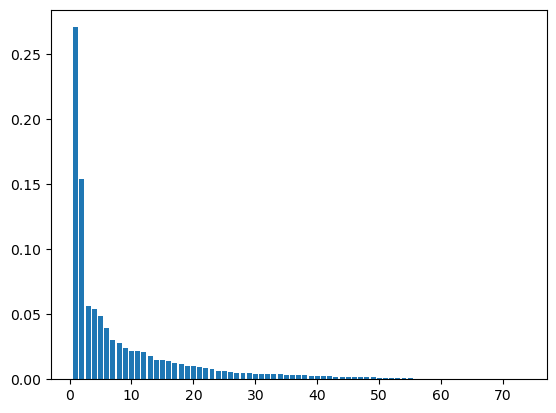

In [495]:
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)

In [496]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

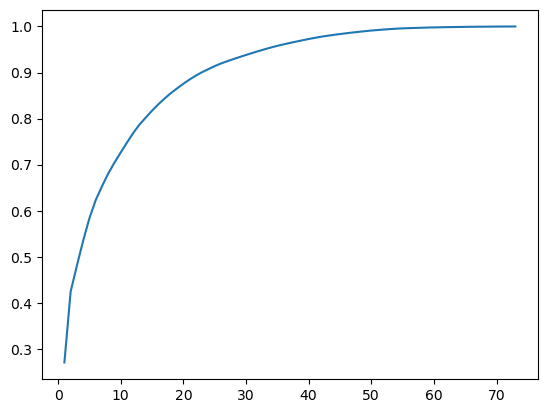

In [497]:
plt.plot(range(1,len(var_cumu)+1), var_cumu)

In [498]:
pc2 = PCA(n_components=20, random_state=42)
newdata = pc2.fit_transform(df_pca_train[scaled_columns])


num_components = newdata.shape[1]  # Determine the number of components dynamically

# Create column names based on the number of components
column_names_dynamic = [f'PC{i+1}' for i in range(num_components)]



df_x = pd.DataFrame(newdata, columns=column_names_dynamic)
df_x.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.840695  0.028750 -0.058365 -0.058622 -0.013891 -0.202831 -0.218002   
1  0.636973 -0.990749 -0.620850 -0.059750  0.215615  0.079094 -0.040084   
2 -0.106986 -0.027631  0.342043  0.057045 -0.069624  0.086853  0.182383   
3 -0.159773 -0.482310 -0.256451 -0.215701 -0.194705 -0.044524 -0.013856   
4 -0.226140  0.092948 -0.113764 -0.464657  0.027685  0.249935  0.374962   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  0.091054 -0.031946 -0.108462  0.213910  0.146352  0.178334 -0.012597   
1  0.487900 -0.312721  0.187325 -0.050902 -0.059246  0.048810 -0.202299   
2  0.024656 -0.111488 -0.147322 -0.175622  0.042748 -0.272841  0.094247   
3  0.158073 -0.247364  0.361570 -0.018389 -0.092055  0.160800 -0.044074   
4  0.072357  0.059218 -0.056977 -0.131382  0.645366 -0.182935  0.182576   

       PC15      PC16      PC17      PC18      PC19      PC20  
0 -0.013900  0.024841 -0.129057 -0.016699  0.041778  0.022766  
1  0.418354  0.198358 -0.195758  0.388307 -0.294702  0.087200  
2 -0.230829  0.235121 -0.248564 -0.012768 -0.196601 -0.074052  
3 -0.008196 -0.001424  0.134550 -0.265542 -0.017965  0.151623  
4 -0.153768 -0.109249 -0.070010 -0.095065 -0.432978  0.038557

In [499]:
df_pca_final = pd.concat([df_x, pca_y], axis=1)

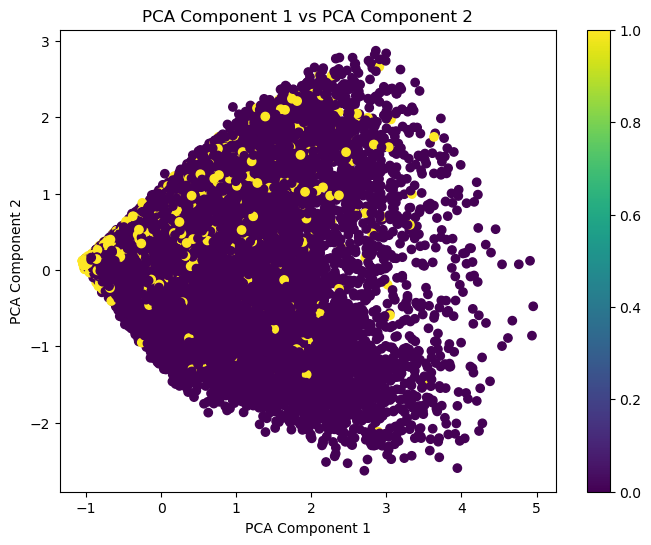

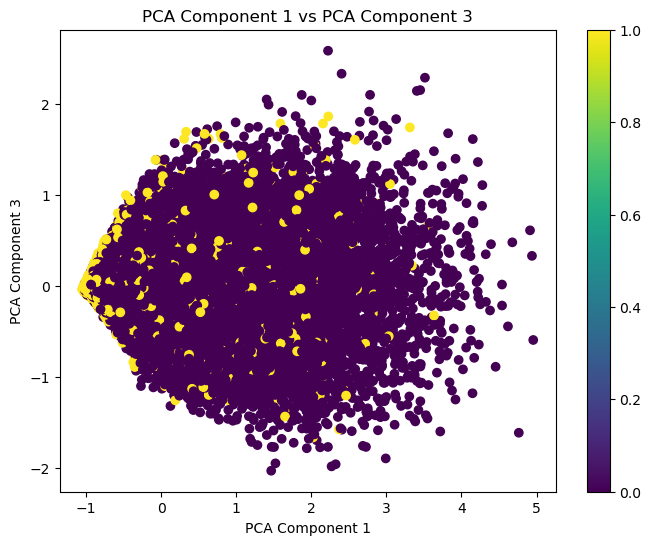

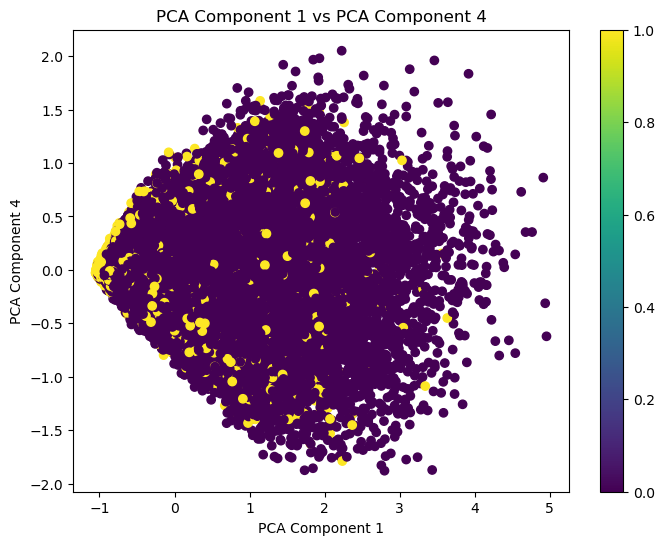

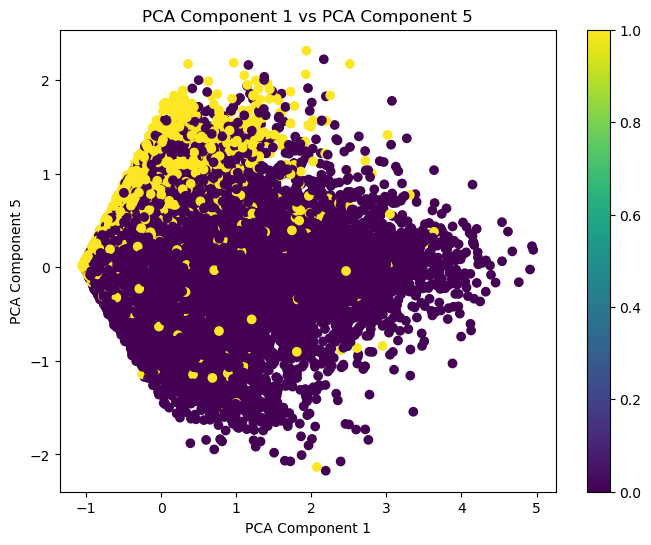

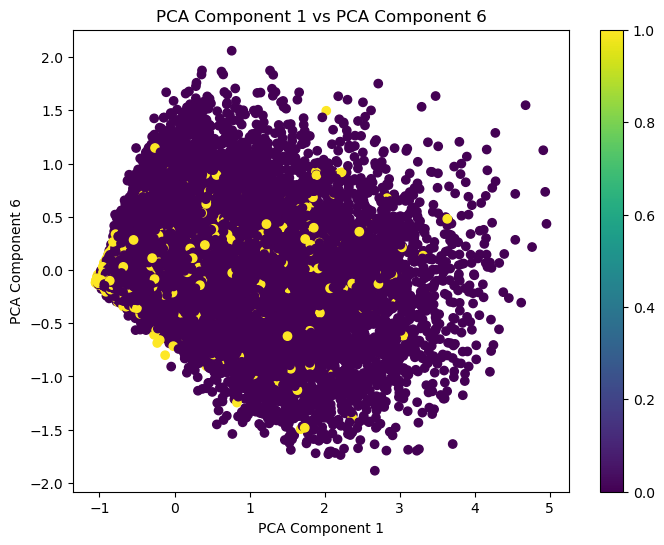

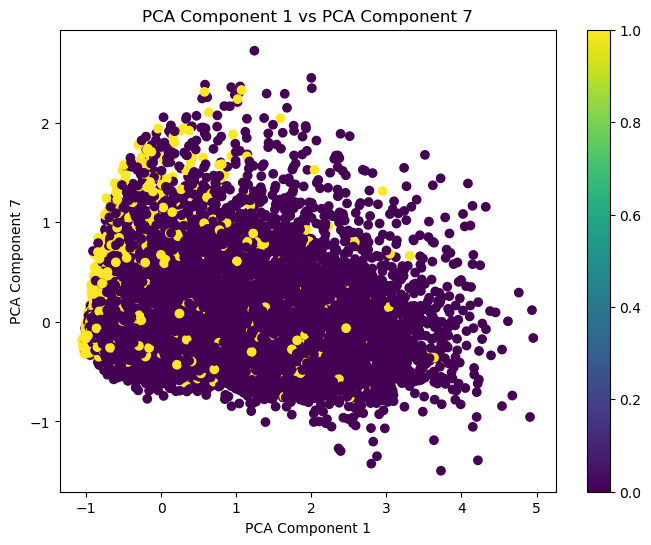

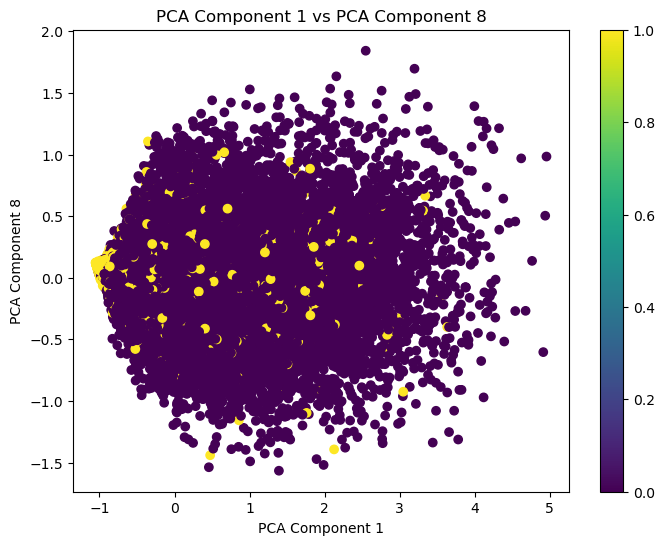

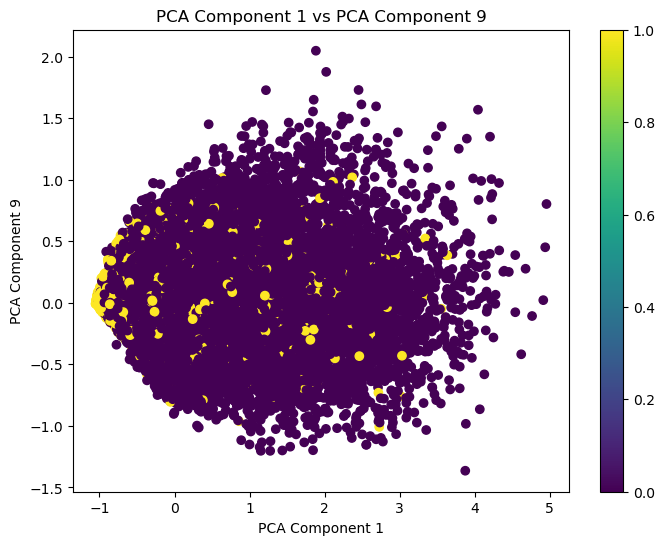

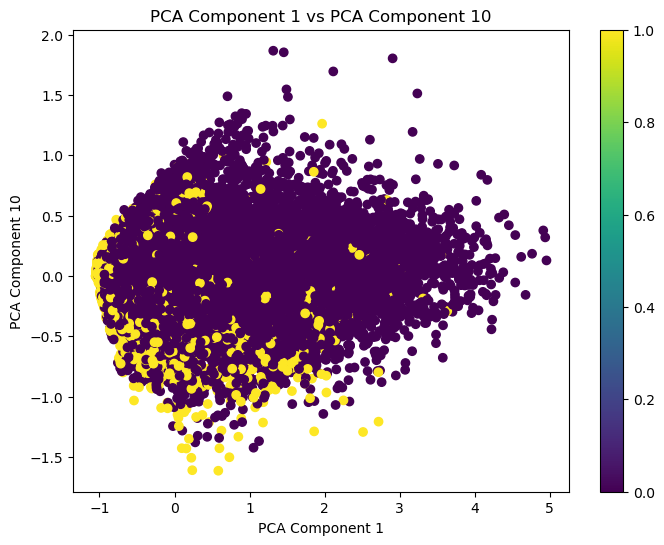

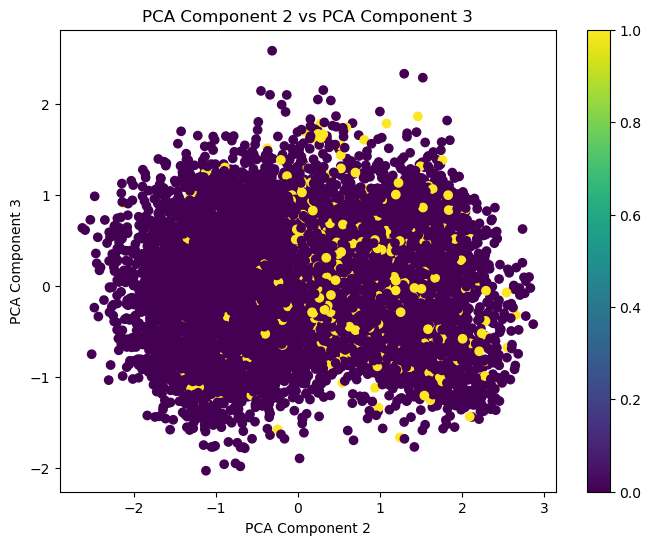

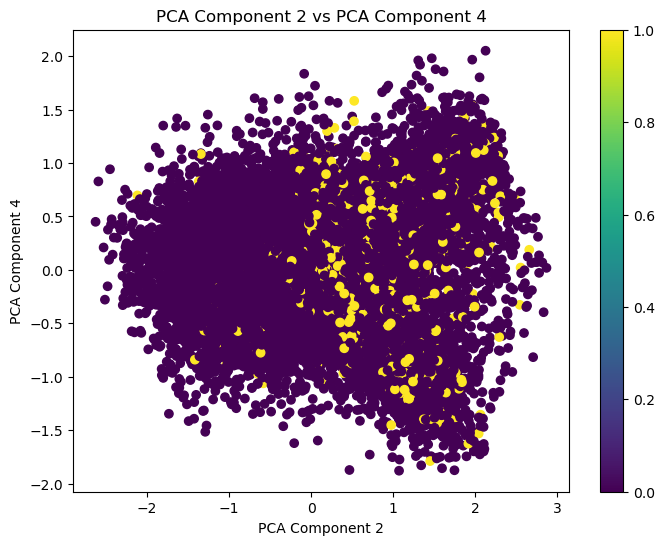

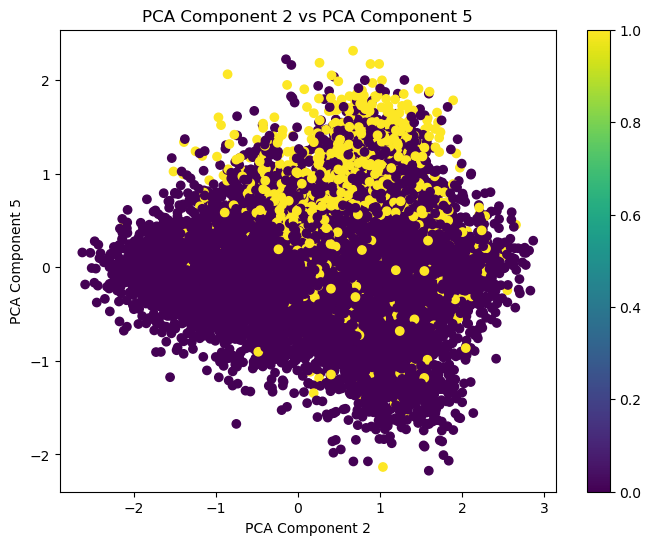

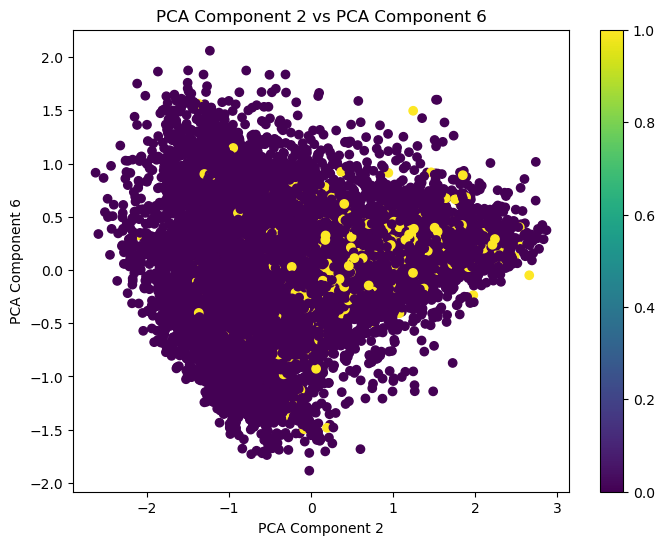

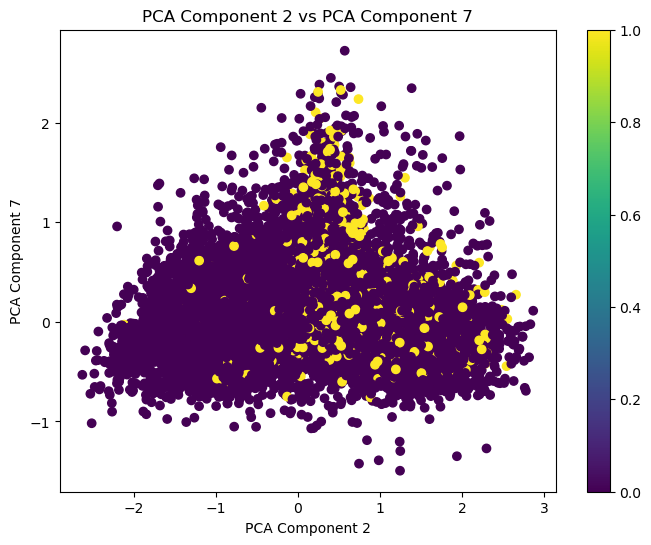

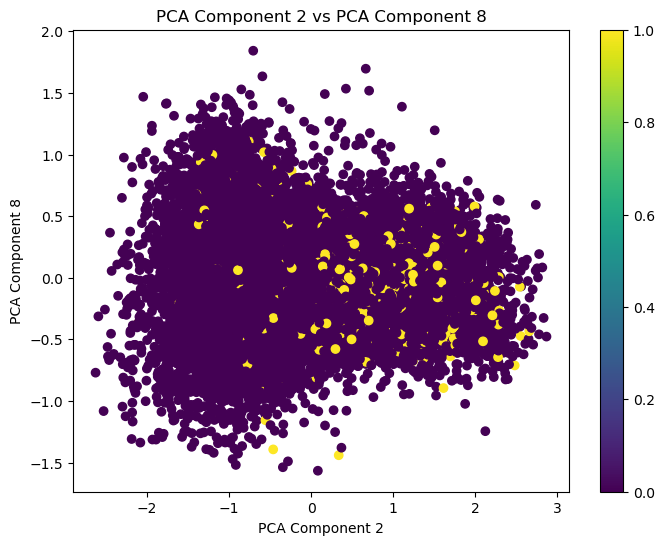

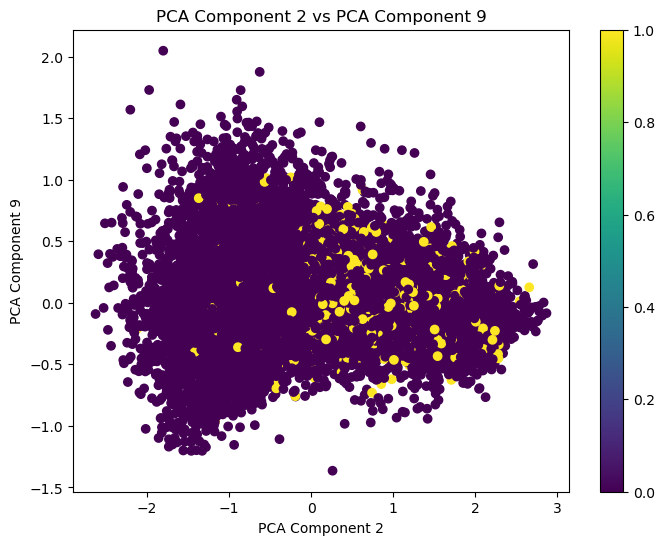

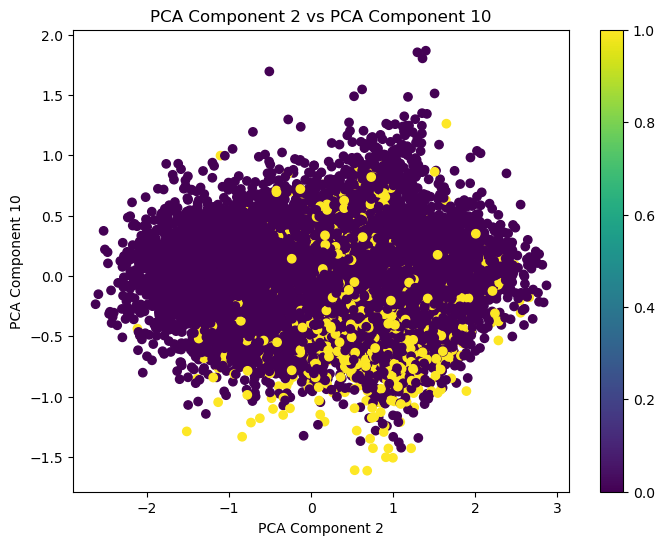

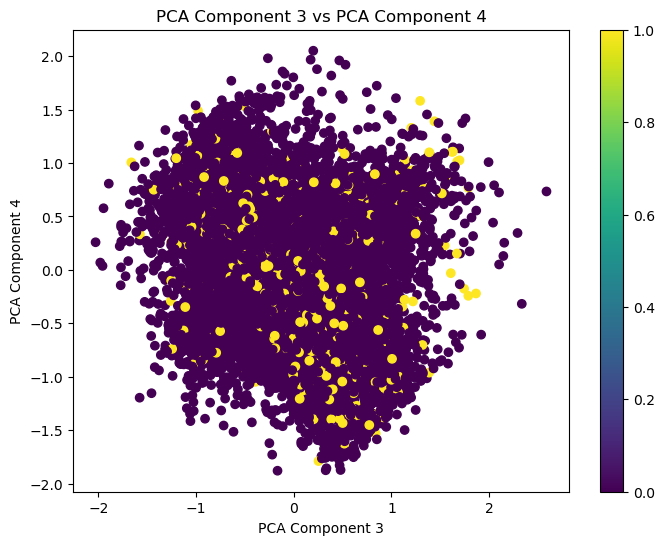

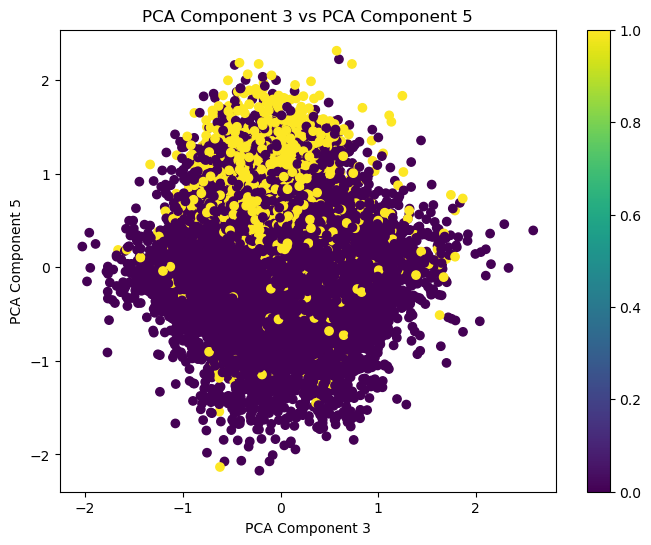

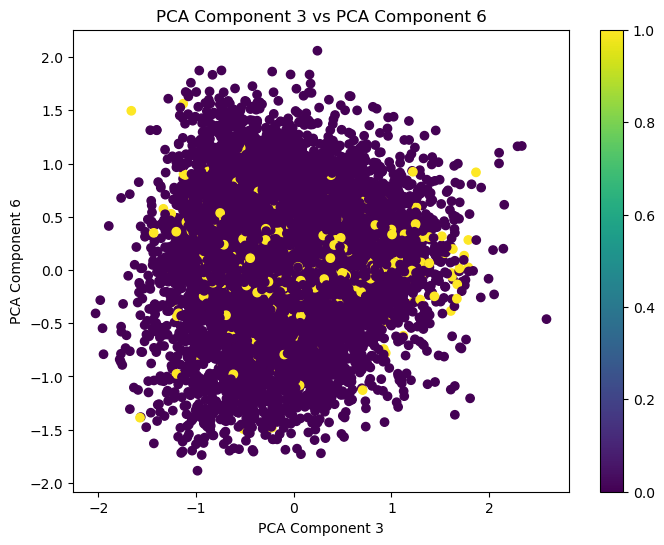

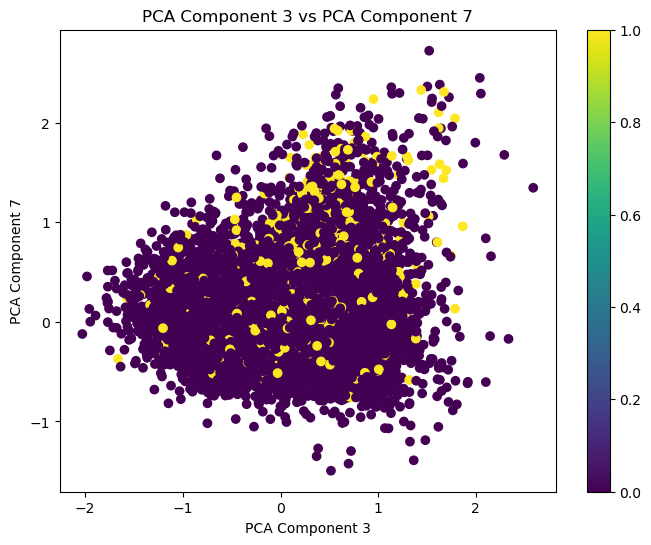

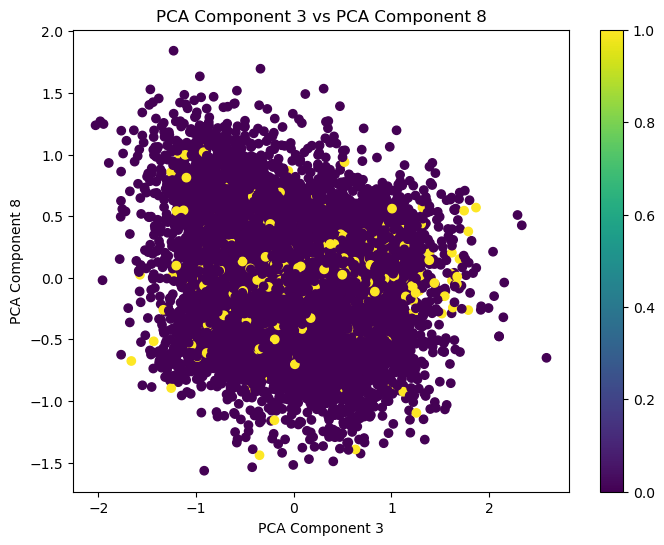

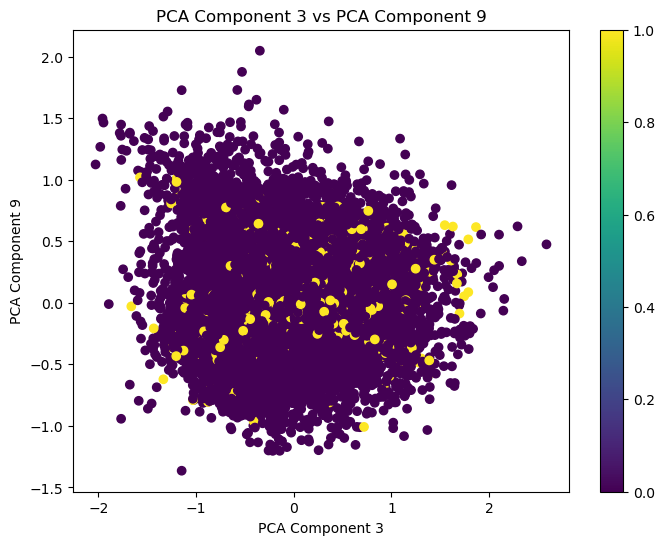

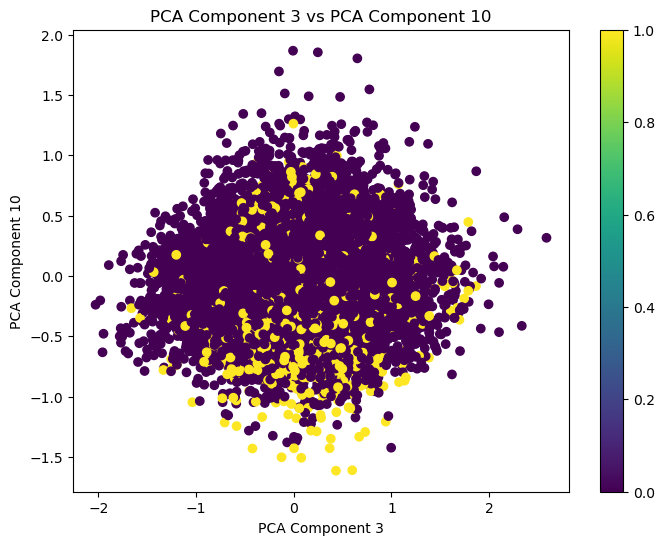

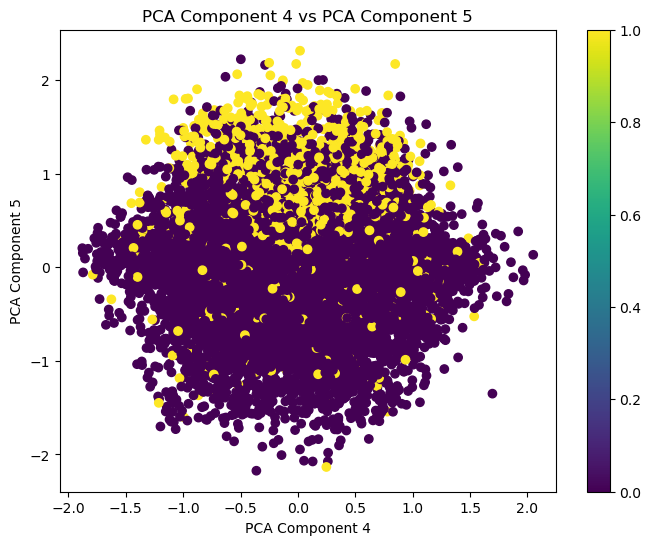

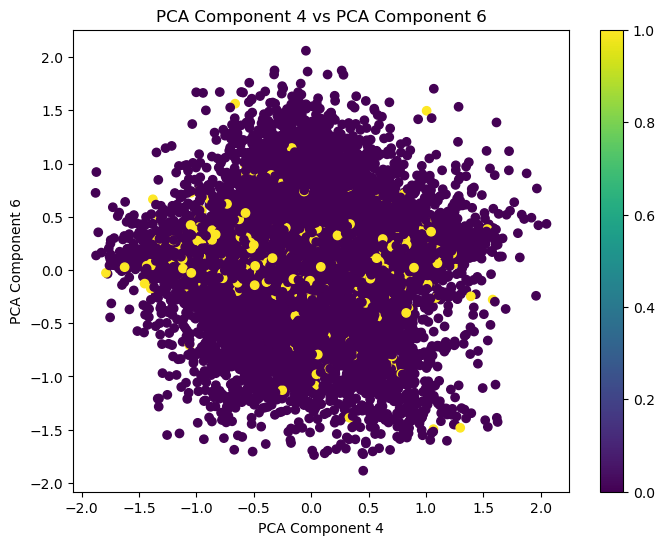

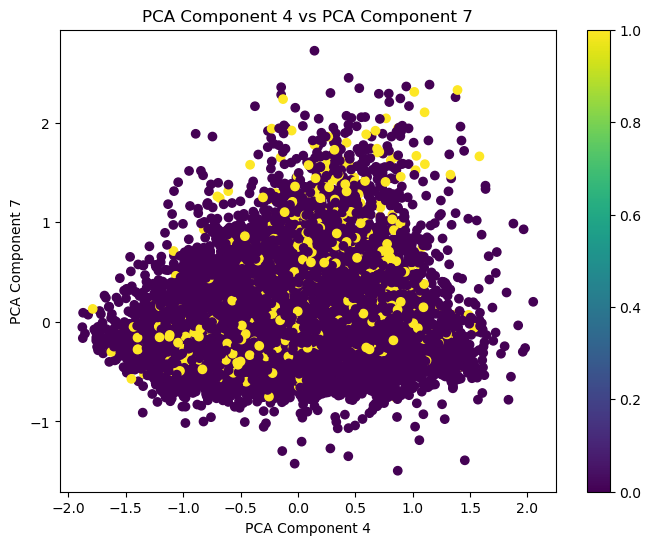

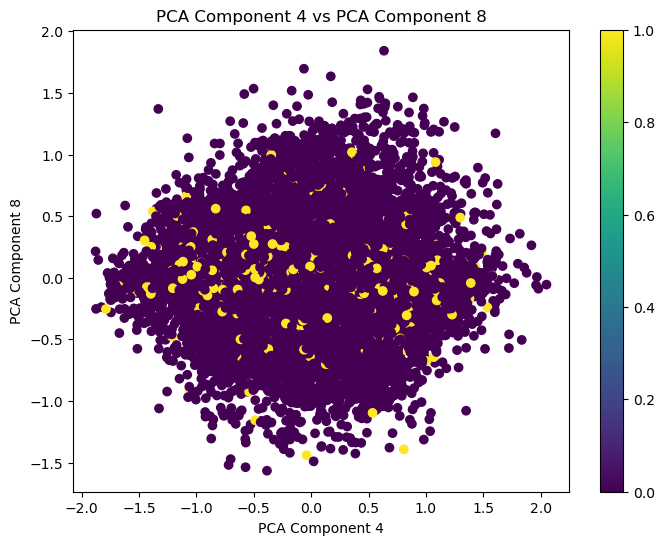

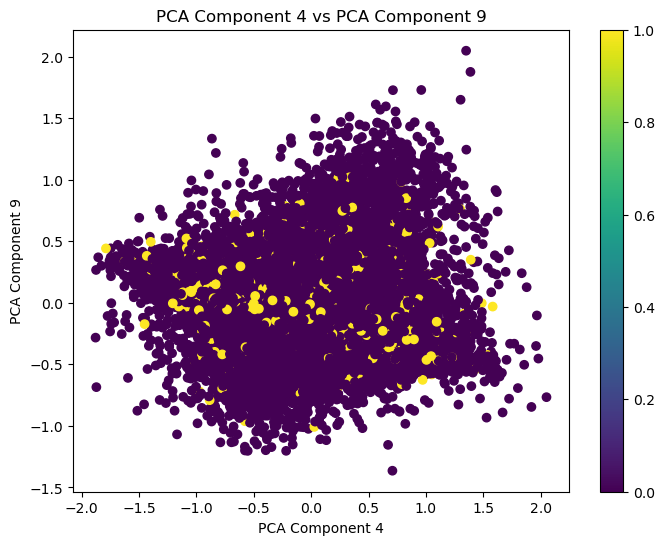

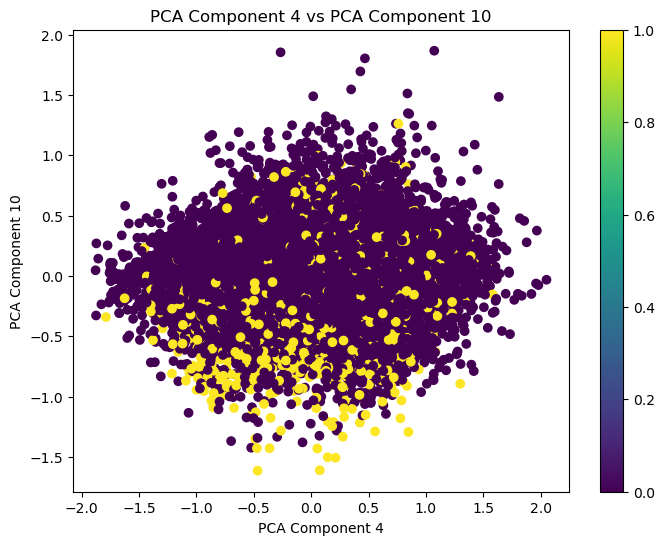

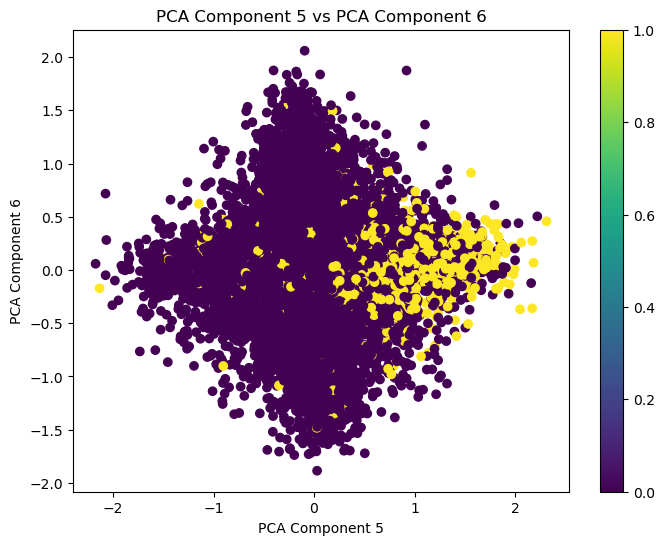

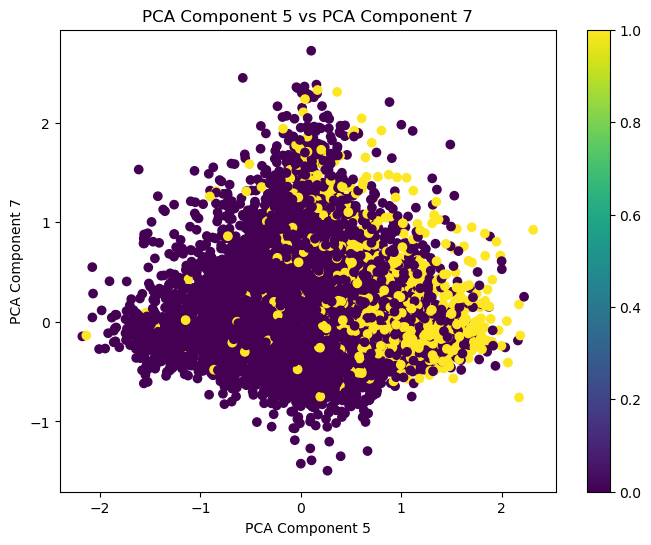

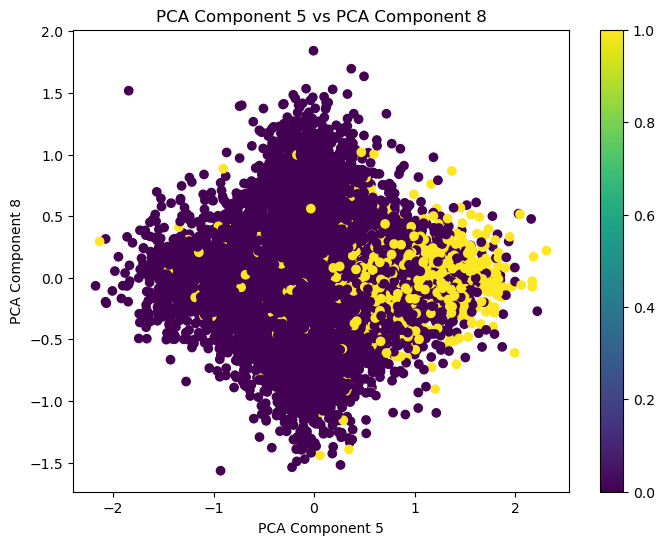

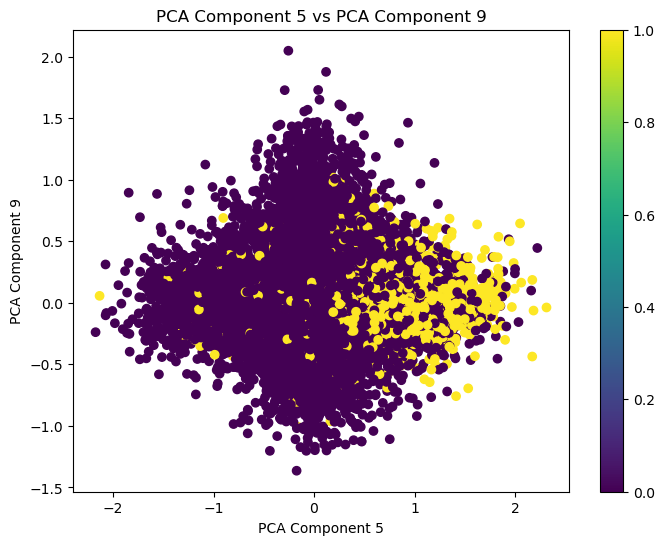

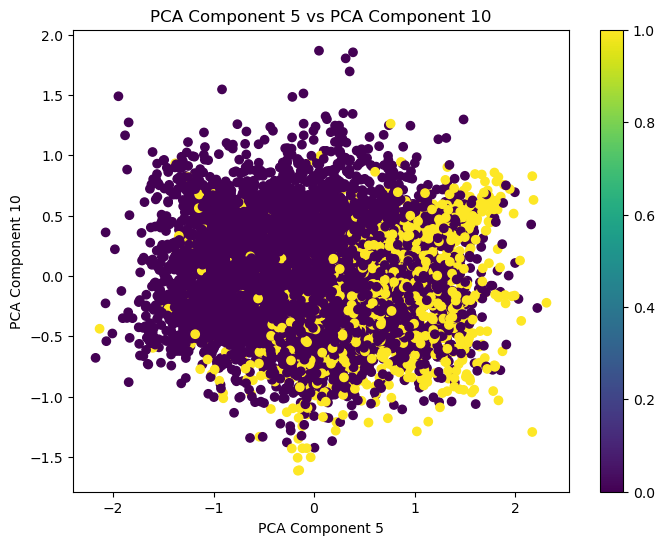

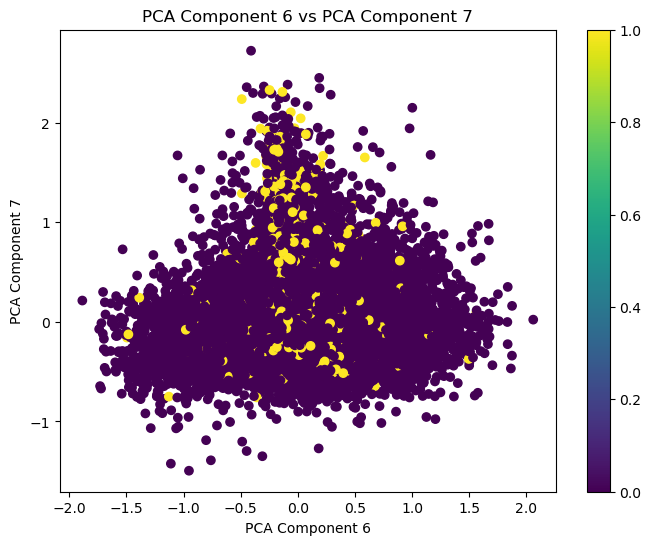

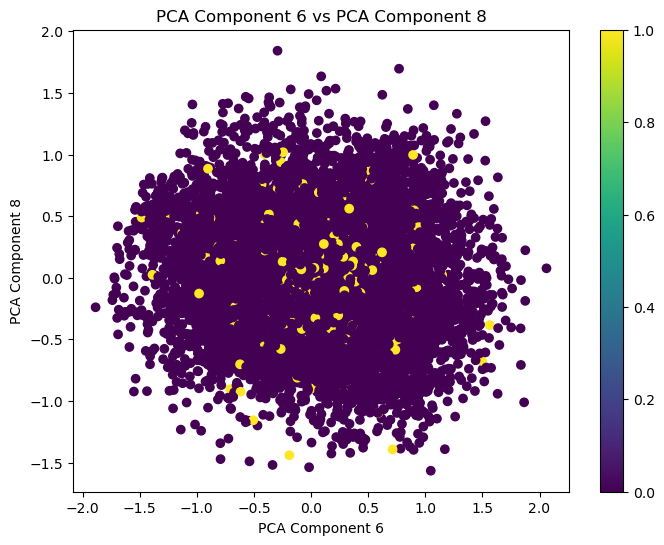

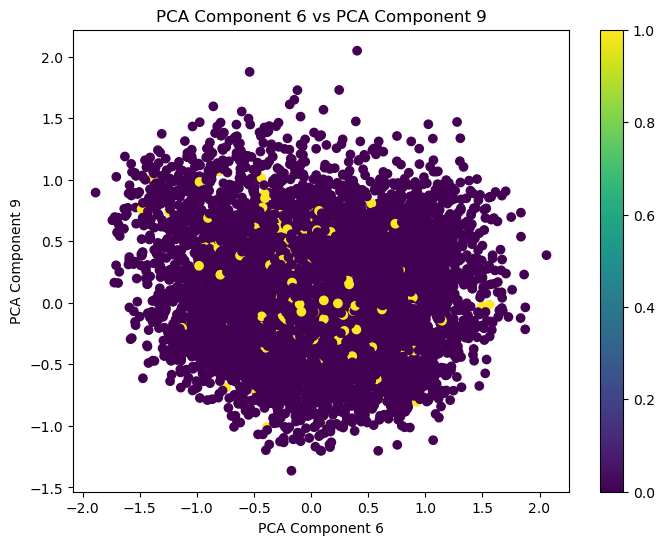

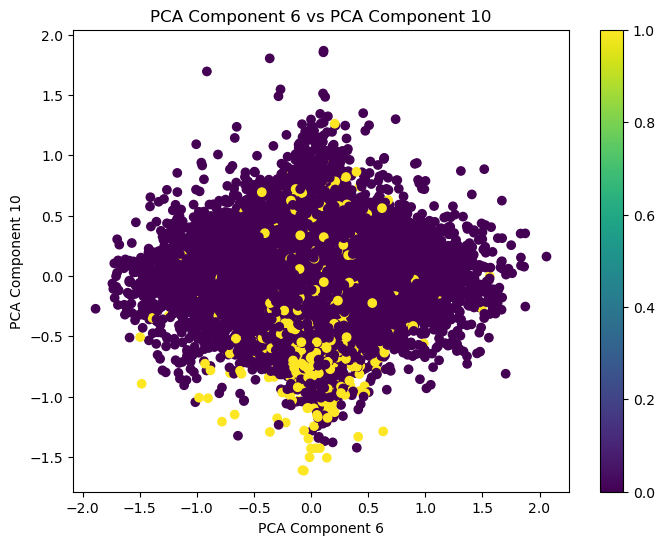

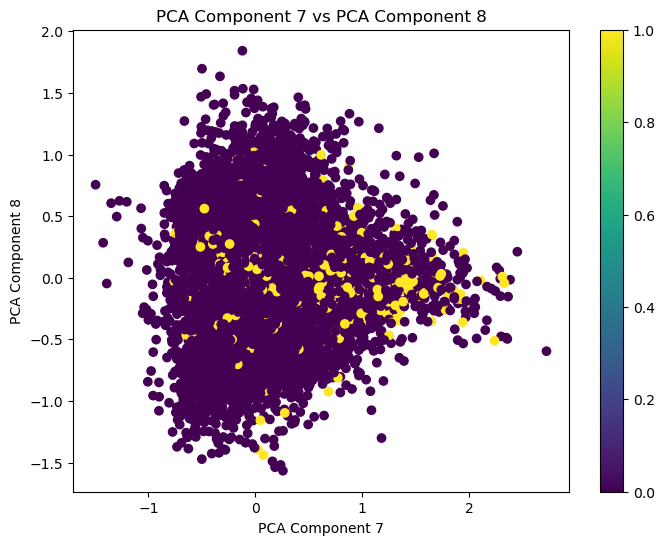

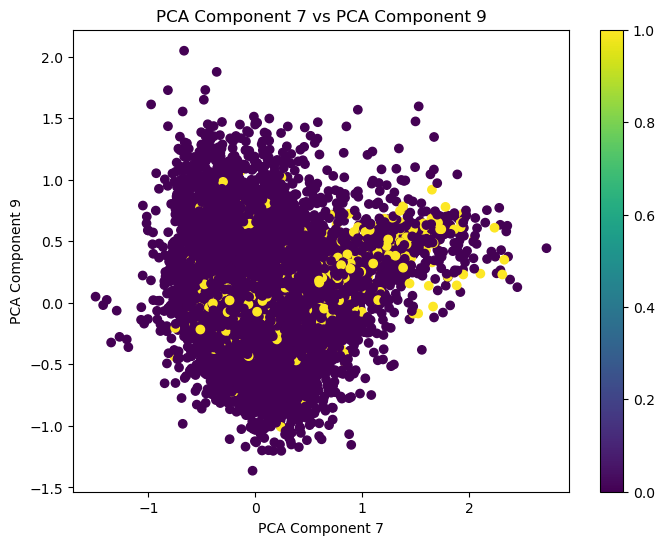

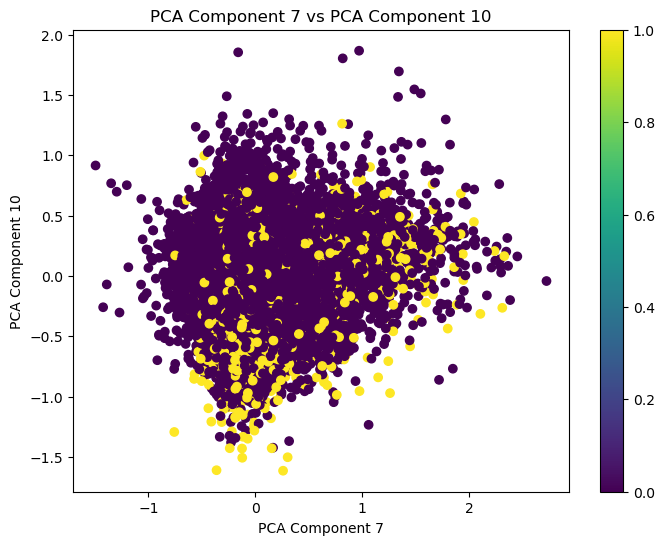

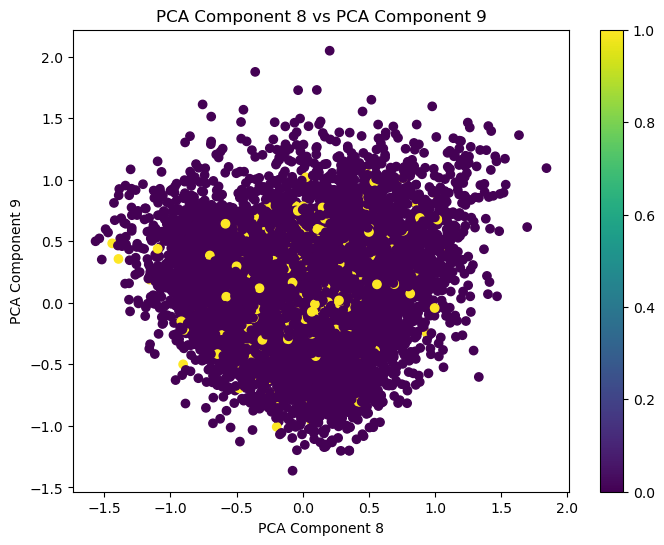

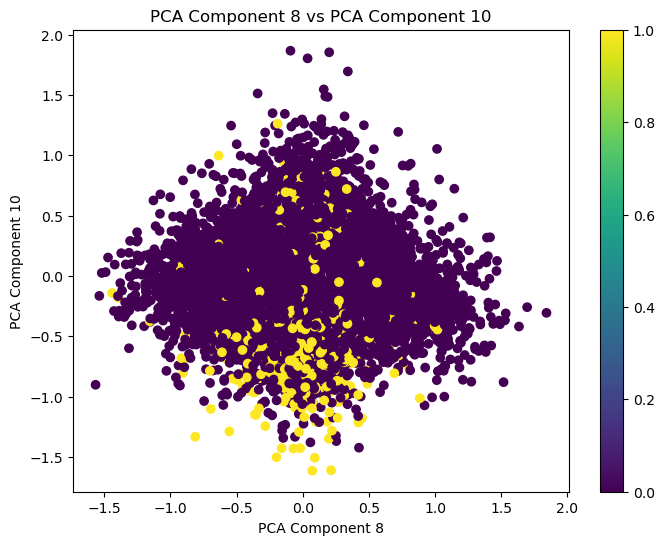

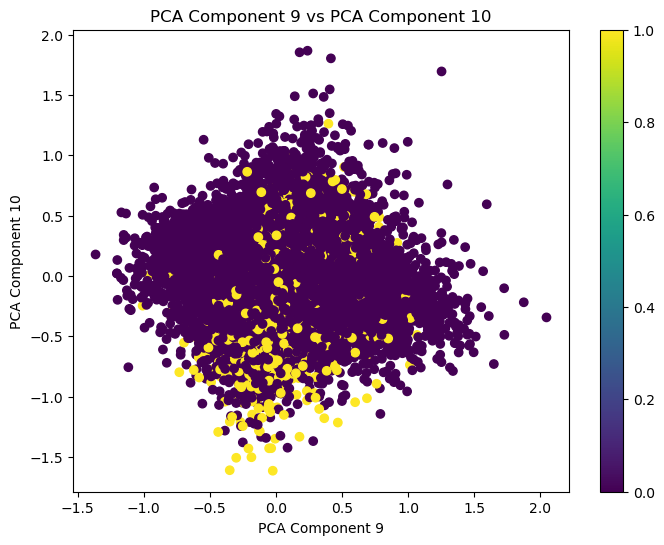

In [500]:
# Create a scatter plot for each pair of PCA components
n_components = 10
for i in range(n_components - 1):
    for j in range(i + 1, n_components):
        plt.figure(figsize=(8, 6))
        #plt.scatter(df_x[:, i], df_x[:, j], c=pca_y, cmap='viridis')  # You can choose a different colormap
        plt.scatter(df_x.iloc[:, i], df_x.iloc[:, j], c=pca_y, cmap='viridis')
        plt.xlabel(f'PCA Component {i+1}')
        plt.ylabel(f'PCA Component {j+1}')
        plt.title(f'PCA Component {i+1} vs PCA Component {j+1}')
        plt.colorbar()
        plt.show()

In [501]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(df_x, pca_y)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [502]:
pca_test_components_123 = pca.transform(df_pca_test[scaled_columns])
pca_test_df_4444 = pd.DataFrame(pca_test_components_123)
pca_test_df_4444.head()
pca_test_components_345 = pd.DataFrame(pca_test_components_123)
pca_test_components_345.head()
selected_columns = pca_test_components_123[:, :20] 
x=lr.predict(selected_columns)
x

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [503]:
df_pca_test.head()

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou    arpu_6    arpu_7  \
3425              0.0             0.0             0.0  0.376111  0.638135   
33067             0.0             0.0             0.0  0.744052  0.641209   
52420             0.0             0.0             0.0  0.490605  0.390955   
5220              0.0             0.0             0.0  0.374193  0.386637   
33958             0.0             0.0             0.0  0.392851  0.420434   

         arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  ...  \
3425   0.365497     0.025887     0.496605     0.000000      0.000053  ...   
33067  0.485791     0.431578     0.267301     0.024623      1.000000  ...   
52420  0.368182     0.104803     0.025999     0.000000      0.061573  ...   
5220   0.407134     0.001342     0.000000     0.000000      0.003125  ...   
33958  0.393903     0.007876     0.028719     0.018599      0.106124  ...   

       sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8       aon  \
3425           0.0          0.0        0.0        0.0        0.0  0.170860   
33067          0.0          0.0        1.0        0.0        0.0  0.169321   
52420          0.0          0.0        0.0        0.0        0.0  0.153928   
5220           0.0          0.0        0.0        1.0        1.0  0.785291   
33958          0.0          0.0        0.0        0.0        0.0  0.463581   

       aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
3425         0.00        0.00         0.0                  1  
33067        0.00        0.00         0.0                  1  
52420        0.00        0.00         0.0                  0  
5220       242.83      297.79         0.0                  0  
33958        0.00        0.00         0.0                  1  

[5 rows x 161 columns]

In [504]:
# Confusion matrix 
confusion = metrics.confusion_matrix(df_pca_test.churn_probability, x )
print(confusion)

[[12430   178]
 [ 1117   275]]


In [505]:
# Let's check the overall accuracy.
metrics.accuracy_score(df_pca_test.churn_probability, x)

0.9075